### <font color= 'white'> S&P 500 PostCovid *Optimizations & ML models*<font> 

##### [![S&P500-PostCovid_ML](https://img.shields.io/badge/Repository-S&P500--PostCovid--ML-020521?style=flat-square&logo=github&logoColor=white)](https://mango-dune-07a8b7110.1.azurestaticapps.net/?repo=EstebanMqz%2FSP500-Risk-Optimized-Portfolios-PostCovid-ML)

##### <font color= 'lightblue'> *Introduction.* <font>

Machine Learning has been around for decades but big data has substantially increased its value. <br>
Nowadays, predictive Machine Learning models are used in most industries including:
- Banking
- Insurance
- Retail
- Manufacturing
- Healthcare
- Government
- Education
- Agriculture
- Energy
- Transportation
- Telecommunications

Descriptive Statistics are made for datasets $X_i$ based on several metrics.<br>
$r_{t}$ $\&$ $\sigma_i$ are generally considered in most industries to integrate Prescriptive and Predictive models for businesses.<br>
In this case, based on certain constraints and objectives, we do so $\forall i \rightarrow X_P$ from $w$ optimizations.<br>

### <font color= 'lightblue'> 0. Requirements. <font>

##### <font color= 'lightblue'> 0.1 <u> Load Dependencies: </u><font>

In [7]:
import functions as fn
import data as dt
import visualizations as vs 

##### <font color= 'lightblue'> 0.2 <u> Install Libs. & Modules: </u><font>

<span style='color:orange'> Project Creators:</span> Create `requirements.txt` file:

<span style='color:lightyellow'> *Skip to `requirements.txt` installation if not contributing to the project.* <font>

In [8]:
docstring = """
# -- -------------------------------------------------------------------------------------- -- # 
# -- project: S&P500-Risk-Optimized-Portfolios-PostCovid-ML                                 -- # 
# -- script: requirements.txt: txt file to download Python modules for execution            -- # 
# -- author: EstebanMqz                                                                     -- # 
# -- license: CC BY 3.0                                                                     -- # 
# -- repository: SP500-Risk-Optimized-Portfolios-PostCovid-ML/blob/main/requirements.txt    -- #                                  
# -- -------------------------------------------------------------------------------------- -- # 
\n
"""

path = fn.get_requirements(docstring)

requirements.txt file created in local path: c:\Users\Esteban\Desktop\Projects\Github\Repos_To-do\Languages\Python\Fin_Sim\Projects\SP500-Risk-Optimized-Portfolios-ML\requirements.txt


<span style='color:green'> Project Users:</span> Install packages in `requirements.txt` file: <br>

In [10]:
fn.library_install("requirements.txt")

Requirements installed.

# -- -------------------------------------------------------------------------------------- -- # 
# -- project: S&P500-Risk-Optimized-Portfolios-PostCovid-ML                                 -- # 
# -- script: requirements.txt: txt file to download Python modules for execution            -- # 
# -- author: EstebanMqz                                                                     -- # 
# -- license: CC BY 3.0                                                                     -- # 
# -- repository: SP500-Risk-Optimized-Portfolios-PostCovid-ML/blob/main/requirements.txt    -- #                                  
# -- -------------------------------------------------------------------------------------- -- # 


numpy >= 1.23.5 
pandas >= 1.4.4 
matplotlib >= 3.5.3 
scipy >= 1.7.3 
sklearn >= 1.0.2 
logging >= 0.5.1.2 
jupyter >= 1.0.0 
yahoofinanicals >= 1.14 
tabulate >= 0.8.9 
IPython >= 8.12.0 
fitter >= 1.5.2 



##### <font color= 'lightblue'> 0.3 <u> Load Libraries & Modules </u><font>

In [97]:

import numpy as np
import pandas as pd
pd.set_option("display.max_rows", None, "display.max_columns", None
              ,"display.max_colwidth", None, "display.width", None)

from io import StringIO
import ast
from fitter import Fitter, get_common_distributions, get_distributions 
import logging
logging.getLogger().setLevel(logging.ERROR)

import matplotlib
import matplotlib.pyplot as plt
plt.style.use("dark_background")
%matplotlib inline

import scipy
import scipy.stats as st
from scipy import optimize
from scipy.optimize import minimize

import sklearn
from sklearn.neighbors import KernelDensity
from sklearn.model_selection import GridSearchCV 
from sklearn import metrics

from yahoofinancials import YahooFinancials 
from tabulate import tabulate
import IPython.display as d

import datetime 
import time
import warnings
warnings.filterwarnings("ignore")
warnings.filterwarnings("ignore", category=UserWarning)

### <font color= 'lightblue'> 1. Data Extraction <font>

The following are the $S\&P500$ quotes symbols from *A-Z*:

<span style='color:lightyellow'> *Fetching a lot of data from Yahoo Finance by batches is required to avoid host disruptions (other sources could be used instead).* <font> &nbsp;

In [13]:
tickers=fn.SP500_tickers(50)
tickers[0][0:5], tickers[-1][0:5]

(['MMM', 'AOS', 'ABT', 'ABBV', 'ACN'], ['ZBH', 'ZION', 'ZTS'])

#### <font color= 'lightblue'> 1.1 <u> Fetching Data </u><font> </span>


<span style='color:lightyellow'> *Skip to 1.2 if you prefer using .csv creation date rather than execution's date.* <font> &nbsp; 


$6_Y$ of adj closes from the $S\&P$ $500$ quotes are fetched *(5min.)*.

In [ ]:
SP_Assets_f = pd.concat([dt.get_historical_price_data(tickers[i][j], 6) 
                         for i in range(0, len(tickers)) for j in range(0, len(tickers[i]))], axis=1)

In [ ]:
SP_f = dt.get_historical_price_data('^GSPC', 6)
SP_f = SP_f[SP_f.index.isin(SP_Assets_f.index)]

Fetched data saved in `Assets_SP500.csv` $\&$ `SP500_index.csv` files in *subdirectory $\rightarrow$ `Data`*

In [ ]:
SP_Assets_f.to_csv("Data/Assets_SP500.csv")   
SP_f.to_csv("Data/SP500.csv")

In [ ]:
SP_Assets_f.head(8)

In [ ]:
SP_Assets_f.tail(8)

#### <font color= 'lightblue'> 1.2 <u> Reading data </u><font> </span>

Row simmetry is checked within data.

In [14]:
SP_r = pd.read_csv("Data/SP500.csv", index_col=0)
SP_Assets_r = pd.read_csv("Data/Assets_SP500.csv", index_col=0)

SP_r.shape, SP_Assets_r.shape

((1509, 1), (1509, 503))

### <font color= 'lightblue'> 2. Descriptive Analytics <font> </span>

##### <font color= 'lightblue'> 2.1 <u>$X_i$ metrics<u> <font>

Sharpe's Ratio is a metric that measures the units of risk *($\small \sigma$)* per unit of excess returns over a risk-free rate *($\small rf$)* :
+ $R_{Sharpe} = \frac{\mu_i - {rf}}{\sigma_i(r_t)}$.
<br>

Sortino's Ratio is a metric that measures the units of negative risks *[$\sigma_{i}\small(r_{t\leq 0})$]* per unit of excess returns over a risk-free rate *($\small rf$)* :
+ $R_{Sortino} = \frac{\mu_i - {rf}}{\sigma_{i}(r_{t\leq 0})}$ 

Selection based on *Sortino's Ratio top 25 from $S\&P500$* is made to avoid risks associated to a loss, for example.

|      |   $\mu_{i{yr}}$ |   $\sigma_{yr}$ |   $R_{Sharpe}$ |   $R_{Sortino}$ |
|:-----|----------------:|----------------:|---------------:|----------------:|
| LLY  |        0.439546 |        0.34004  |       1.24293  |         2.06968 |
| EQT  |        0.739324 |        0.650924 |       1.10984  |         1.9497  |
| PWR  |        0.549169 |        0.398733 |       1.3349   |         1.93998 |
| FSLR |        0.574193 |        0.530718 |       1.05007  |         1.65684 |
| NVDA |        0.603997 |        0.557493 |       1.0531   |         1.65645 |
| MRNA |        0.794179 |        0.798233 |       0.973749 |         1.62732 |
| MCK  |        0.334021 |        0.306705 |       1.03396  |         1.57559 |
| STLD |        0.553778 |        0.502902 |       1.06756  |         1.53834 |
| NUE  |        0.510443 |        0.462683 |       1.0667   |         1.53052 |
| ON   |        0.649095 |        0.616904 |       1.02479  |         1.51499 |
| CDNS |        0.424275 |        0.39579  |       1.02927  |         1.49501 |
| FCX  |        0.569215 |        0.581038 |       0.950565 |         1.45907 |
| CMG  |        0.383529 |        0.398468 |       0.920096 |         1.44333 |
| SNPS |        0.376237 |        0.381583 |       0.941702 |         1.40487 |
| ANET |        0.415803 |        0.428133 |       0.931728 |         1.39028 |
| TSCO |        0.373575 |        0.333879 |       1.06828  |         1.377   |
| GWW  |        0.334868 |        0.325289 |       0.977495 |         1.36794 |
| AAPL |        0.334813 |        0.355936 |       0.893174 |         1.29789 |
| DVN  |        0.665618 |        0.688414 |       0.942337 |         1.28089 |
| AZO  |        0.347964 |        0.316094 |       1.04736  |         1.23099 |
| ORLY |        0.335802 |        0.31142  |       1.02403  |         1.21046 |
| FTNT |        0.456049 |        0.483749 |       0.907804 |         1.20397 |
| GIS  |        0.236349 |        0.241936 |       0.907056 |         1.18754 |
| DE   |        0.347819 |        0.369404 |       0.89582  |         1.18613 |
| AJG  |        0.285816 |        0.292782 |       0.918486 |         1.10845 |

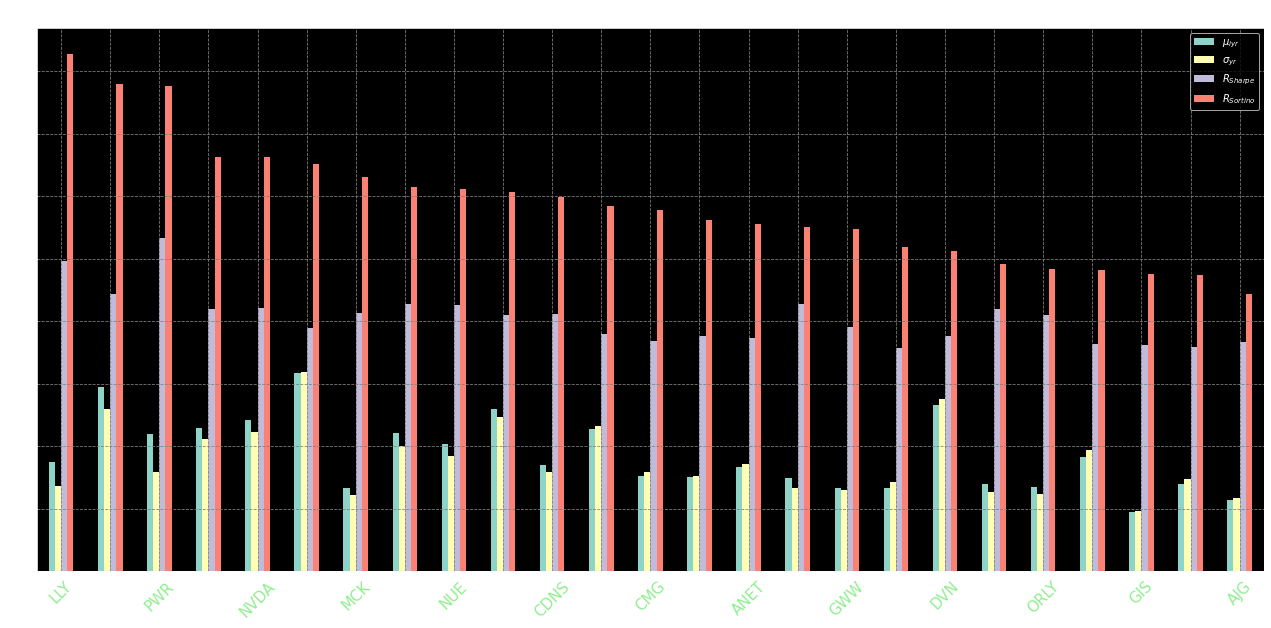

In [15]:
today = (datetime.date.today()).strftime("%Y-%m-%d")
Sortino25 = vs.selection_data(SP_Assets_r.loc["2020-03-02":today], 0.0169, "S&P 500 Metrics from 2020-03-02 to " +str(today), 25)

The *$AIC$ Akaike $\&$ $BIC$ Bayesian Information Criterion* models are estimators of prediction errors in the *Log-Likelihood* for fitted distributions.<br>
Minimum relative values for $AIC$ and $BIC$ are usually preferred for the 104 continous distributions in `Fitter` *(see refs.)* used to model $X_i$ resampled data to $W, M$   $\&$ $Q$ periods $P$.<br>
Their goodness of fit is inversely related so they tend to be used together to avoid risks of under $\&$ over fitting. Their formulas are defined by:
+ $AIC = 2k - 2ln(\hat{L})$<br>
+ $BIC = kln(n) - 2ln(\hat{L})$<br><br>

*where:*<br>

 $k$ = Params. in  model.<br>
 $n$ = No° of observations.<br>
 $\hat{L}$ = $Likelihood_{f_{max.}}$.<br>

In [16]:
dist=([d for d in dir(st) if isinstance(getattr(st, d), getattr(st, "rv_continuous"))])[0:60]
P = [["W", "Weekly"], ["M", "Monthly"], ["Q", "Qtrly."]]
color=["lightyellow", "lightblue", "lightgreen"]

,count,mean,std,min,2.5%,25%,50%,75%,95%,max,mode,skewness,kurtosis
LLY,166.0,0.008416,0.043732,-0.116610,-0.078719,-0.013882,0.007220,0.027725,0.080003,0.144703,-0.116610,0.121873,0.757302
EQT,166.0,0.014157,0.091365,-0.277221,-0.141849,-0.036468,0.010974,0.054020,0.166913,0.461275,-0.277221,0.722488,3.586778
PWR,166.0,0.010515,0.053427,-0.242957,-0.101968,-0.014759,0.011491,0.039792,0.090886,0.191668,-0.242957,-0.492148,3.453576
FSLR,166.0,0.010995,0.075741,-0.176132,-0.115834,-0.031713,0.008080,0.053837,0.140650,0.330538,-0.176132,0.652541,1.912665
NVDA,166.0,0.011565,0.066747,-0.170943,-0.124605,-0.030425,0.007479,0.052058,0.119534,0.220784,-0.170943,0.110381,0.360265
MRNA,166.0,0.015207,0.117293,-0.341603,-0.215685,-0.049316,0.009982,0.064982,0.217646,0.440123,-0.341603,0.434138,1.686632
MCK,166.0,0.006396,0.037406,-0.105765,-0.058878,-0.014428,0.005619,0.028538,0.065580,0.150352,-0.105765,0.147654,0.857251
STLD,166.0,0.010604,0.065971,-0.165925,-0.118953,-0.032763,0.015284,0.047276,0.113702,0.180117,-0.165925,-0.056469,0.003779
NUE,166.0,0.009774,0.065099,-0.195669,-0.119379,-0.029620,0.012572,0.050157,0.104834,0.196097,-0.195669,-0.172740,0.510265
ON,166.0,0.012429,0.073267,-0.202086,-0.141261,-0.033269,0.013982,0.051833,0.130419,0.243759,-0.202086,0.130595,1.160513


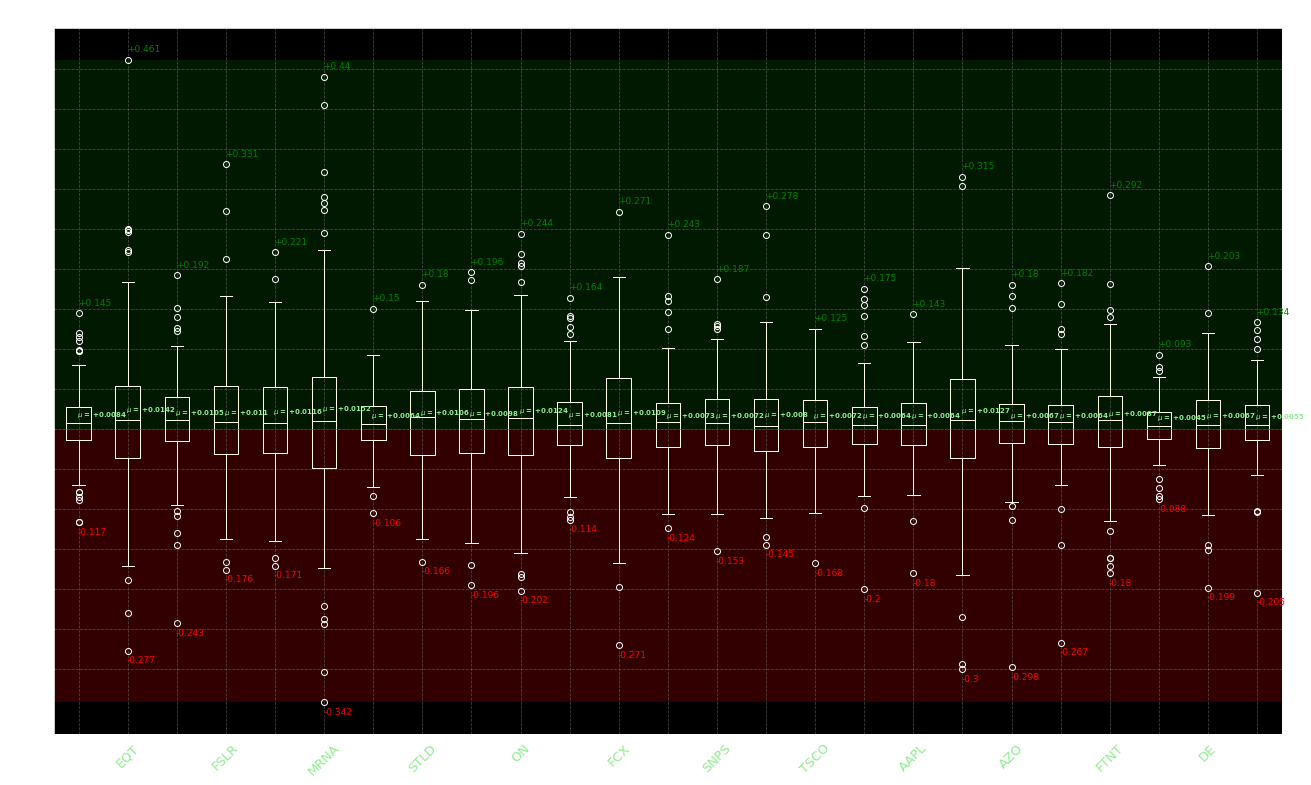

,count,mean,std,min,2.5%,25%,50%,75%,95%,max,mode,skewness,kurtosis
LLY,39.0,0.035824,0.086717,-0.120714,-0.116254,-0.016603,0.038223,0.099590,0.149452,0.218815,-0.120714,-0.186039,-0.814274
EQT,39.0,0.060256,0.190651,-0.303702,-0.219701,-0.027932,0.040628,0.125942,0.288209,0.785913,-0.303702,1.296629,3.858506
PWR,39.0,0.044758,0.086778,-0.147139,-0.120606,0.007632,0.052844,0.096693,0.179521,0.253868,-0.147139,-0.042665,0.088955
FSLR,39.0,0.046798,0.154780,-0.194779,-0.186334,-0.072388,0.041993,0.179933,0.270241,0.404251,-0.194779,0.248729,-0.811802
NVDA,39.0,0.049227,0.150344,-0.368077,-0.213133,-0.022407,0.064015,0.164835,0.248705,0.303955,-0.368077,-0.573224,0.016013
MRNA,39.0,0.064727,0.252222,-0.377496,-0.347122,-0.095784,0.052633,0.157402,0.478104,0.871581,-0.377496,0.824606,1.286624
MCK,39.0,0.027223,0.064121,-0.076684,-0.074690,-0.016917,0.013953,0.058464,0.139089,0.209131,-0.076684,0.801247,0.374337
STLD,39.0,0.045134,0.118828,-0.240008,-0.138137,-0.054193,0.048125,0.117075,0.222968,0.293126,-0.240008,-0.047771,-0.426445
NUE,39.0,0.041602,0.137570,-0.224513,-0.201299,-0.047855,0.027728,0.133603,0.270440,0.309861,-0.224513,0.113514,-0.736012
ON,39.0,0.052902,0.132410,-0.264716,-0.184352,0.011152,0.053626,0.139175,0.264338,0.298621,-0.264716,-0.341829,-0.156725


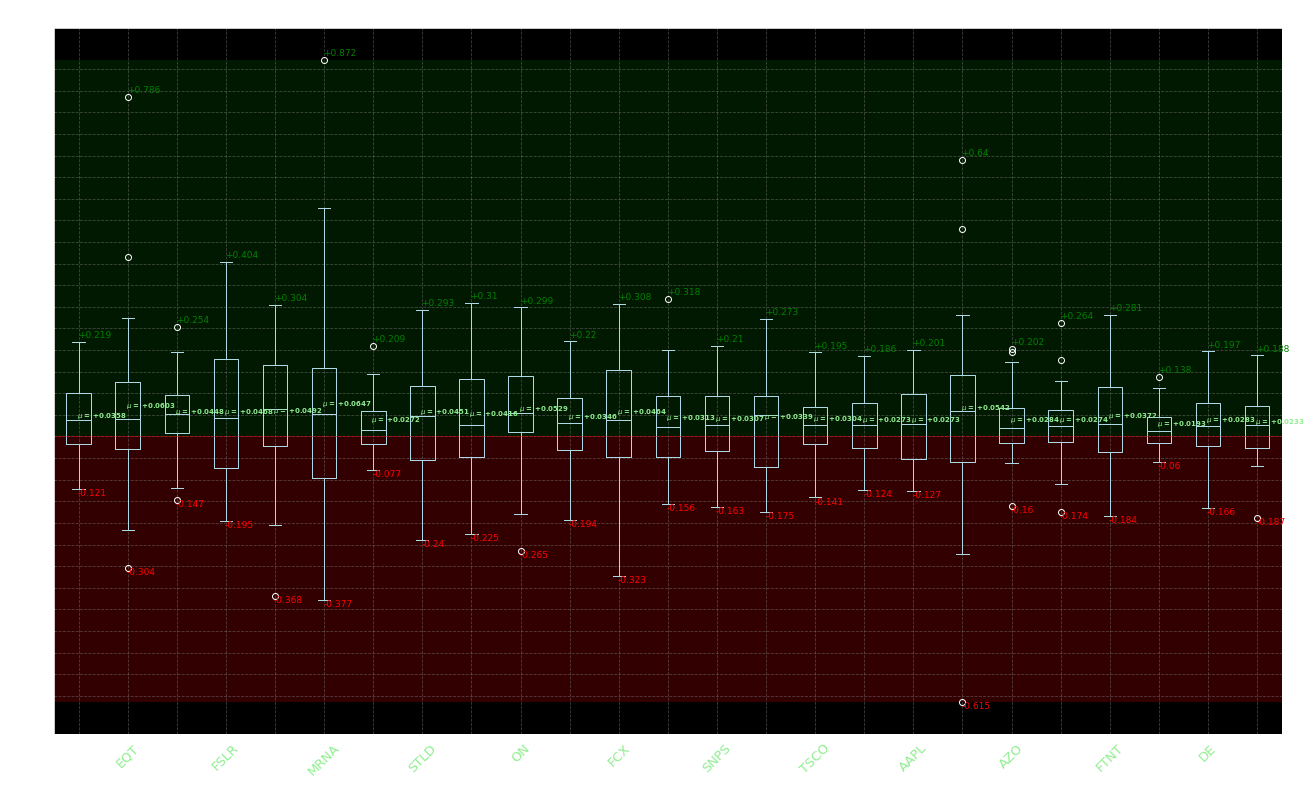

,count,mean,std,min,2.5%,25%,50%,75%,95%,max,mode,skewness,kurtosis
LLY,14.0,0.099795,0.101480,-0.093015,-0.080354,0.024486,0.128494,0.184271,0.223397,0.224663,-0.093015,-0.492581,-0.888542
EQT,14.0,0.167857,0.220751,-0.144545,-0.111848,0.022286,0.110250,0.259772,0.538473,0.619836,-0.144545,0.667261,-0.504785
PWR,14.0,0.124684,0.138050,-0.147139,-0.107089,0.029535,0.144288,0.236734,0.316429,0.323224,-0.147139,-0.241660,-0.812972
FSLR,14.0,0.130365,0.278333,-0.185890,-0.185765,-0.080125,0.065215,0.352624,0.535367,0.703811,-0.185890,0.549166,-0.771473
NVDA,14.0,0.137132,0.305133,-0.526957,-0.415047,-0.007298,0.050473,0.388629,0.512975,0.680798,-0.526957,-0.289932,-0.007561
MRNA,14.0,0.180311,0.384479,-0.298813,-0.298552,-0.134548,0.127955,0.488762,0.721416,0.895174,-0.298813,0.336396,-1.157256
MCK,14.0,0.075836,0.093569,-0.061134,-0.056429,-0.000452,0.061772,0.143454,0.219828,0.228284,-0.061134,0.161926,-1.112913
STLD,14.0,0.125730,0.176597,-0.201306,-0.178503,0.025543,0.148657,0.259651,0.347655,0.349931,-0.201306,-0.393424,-0.883680
NUE,14.0,0.115891,0.186968,-0.318235,-0.247524,0.054692,0.177537,0.201086,0.345083,0.436284,-0.318235,-0.694839,0.456883
ON,14.0,0.147371,0.241911,-0.264716,-0.235315,-0.022043,0.155318,0.297463,0.471730,0.551668,-0.264716,-0.032399,-0.985170


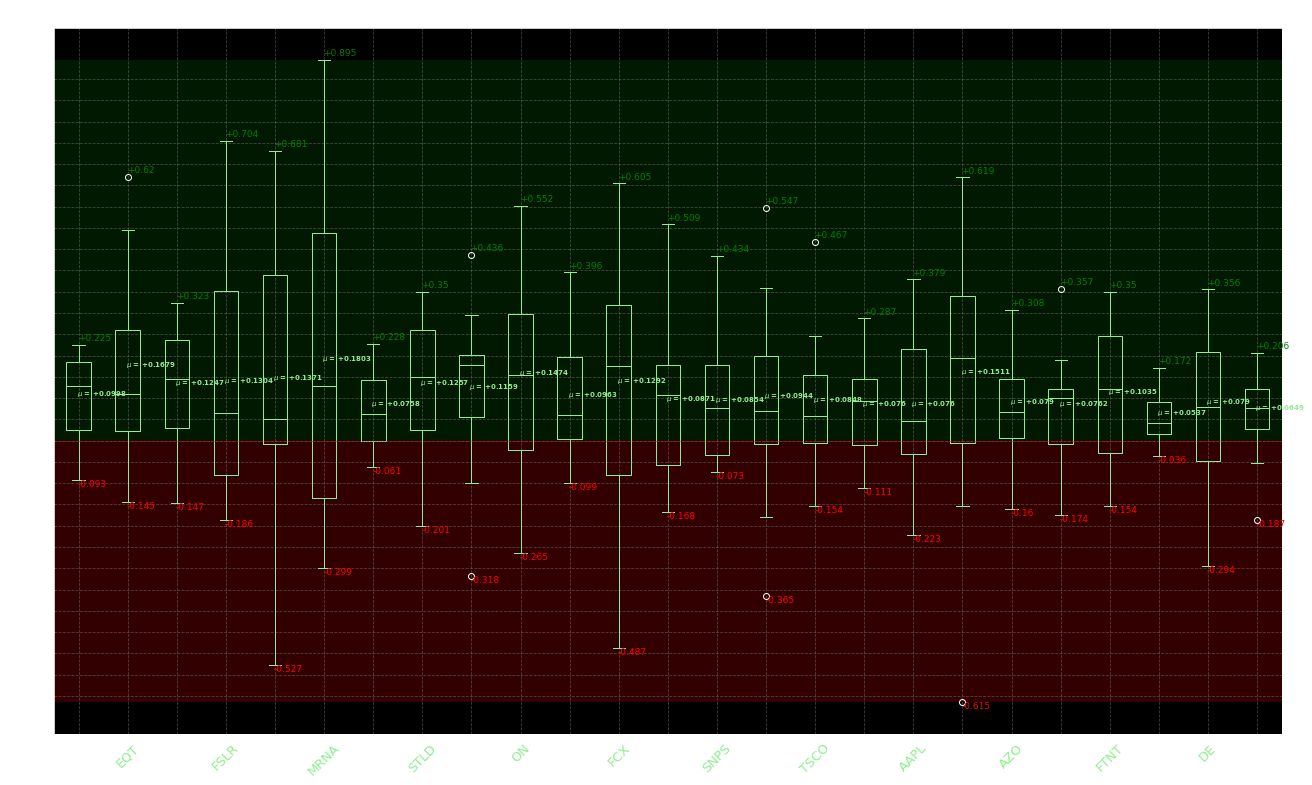

In [49]:
describe = [vs.Stats(SP_Assets_r.loc["2020-03-02":today], Sortino25[2], P[i][0],
                     "S&P 500 Resampling Stats for Sortino Selection on a " + str(P[i][1]) + " basis from ", "2020-03-02", today,
                    [.025, .25, .5, .75, .95], dist, color=color[i]) for i in range(0, len(P))]


Fitted distributions Params., $AIC$ $\&$ $BIC$  $\forall X_i$ resampled datasets are the following:

In [88]:
fn.format_table(describe)

,params,AIC,BIC
"(LLY Wk,)","{'dgamma': (1.1155935501641132, 0.007947416400460976, 0.028920842833122455)}","{'ksone': (1.0289833230613863, -0.11660961387226954, 0.26131254695466877)}","{'laplace': (0.0072199066916045496, 0.032257637981852084)}"
"(EQT Wk,)","{'dgamma': (1.2883618553078475, 0.013014023066540295, 0.05109770895417208)}","{'ksone': (1.1931863038602493, -0.2772215367915596, 0.7384967538230578)}",NaN
"(PWR Wk,)","{'dweibull': (1.097388432203338, 0.011327741791083869, 0.039570430990837145)}","{'gausshyper': (20.635744835976116, 20.6168712008431, -14.615259732999174, 14.919911463899052, -0.49412958851984556, 0.8079496464863256)}","{'hypsecant': (0.011242347003890105, 0.03258369500675523)}"
"(FSLR Wk,)","{'dgamma': (1.3986179834819248, 0.010611454471981559, 0.0409538940058755)}","{'ksone': (1.0000014602804805, -0.1761319119807018, 0.5073448951371986)}",NaN
"(NVDA Wk,)","{'genhyperbolic': (3.404336684446455, 3.9017978683111165, 0.3149405338036833, -0.004409494380740608, 0.08653153627790564)}","{'ksone': (1.001738788640584, -0.17094344377718526, 0.39172773420720064)}","{'hypsecant': (0.010055337742196848, 0.04452991769503606)}"
"(MRNA Wk,)","{'laplace': (0.009982340951015578, 0.08435518748586332)}","{'ksone': (1.0000058679174773, -0.34160366964310773, 0.7817507795230166)}",NaN
"(MCK Wk,)","{'gennorm': (1.4359639782764422, 0.005987359492718107, 0.04180682805876898)}","{'ksone': (1.099511516928105, -0.10576543172407438, 0.2561178021395615)}","{'hypsecant': (0.006257880592960762, 0.024523463788111696)}"
"(STLD Wk,)","{'laplace_asymmetric': (1.0570382183044513, 0.016204615960424728, 0.050489198028360875)}","{'ksone': (1.0939031782181035, -0.16592488409140527, 0.3460421963405318)}","{'laplace': (0.015283837068792994, 0.05071113614447756)}"
"(NUE Wk,)","{'burr': (13.608970755142348, 0.42021805503611454, -0.32470009626717333, 0.3751322567883745)}","{'ksone': (1.0461344078453032, -0.19566951827858237, 0.3917660973854672)}","{'hypsecant': (0.01176010563655502, 0.04302030162532191)}"
"(ON Wk,)","{'hypsecant': (0.012162883067067467, 0.046353666987686844)}","{'ksone': (1.088379284147189, -0.20209773602334669, 0.44585648931008515)}",NaN


### <font color= 'lightblue'> 3. Prescriptive Analytics <font> </span>

##### <font color= 'lightblue'> 3.1 <u>$X_P$<u> Optimizations Prescriptive Models <font>

<span style='color:lightgray'> *Equal weighted datasets are omitted from the analysis for simplicity purposes.* <font>

If we have $n$ unequally weighted datasets $X_i=1,2,.., n$, their weighted average can be concluded:<br>

$$\mu_{P} = \sum_{i=1}^{n} w_{i} \mu_{{X_{i}}}$$ 

For $X_P$ variance $\sigma^2_P$ we need the correlation coefficients for $X_{i,j}$ expressed as $\rho_{i j}$ = $\frac{Cov(X_i, X_{j})}{\sigma_{i} \sigma_{j}}$ and thus, their fluctuations directional relationship.<br>
So it can be expressed as:

$$\sigma^2_P=\sum_{i=1}^{n}\sum_{j=1}^{n}w_{i}w_{j}\sigma_{i}\sigma_{j}\rho_{ij}$$ 


By substitution we are left with: 

$$\sigma^2_P = \sum_{i=1}^{n}\sum_{j=1}^{n}w_{i}w_{j}Cov(X_i, X_j)$$

Which needs to be expressed as a product of matrices $\times$ vectors:<br>

$\sigma^2_{P} = \vec{w}^T \times Cov_{i,j} \times \vec{w}$<br>

Expressed as the following in its expanded form:<br> 

$$\sigma^2_{P} = {\left[\begin{array}{cccc}w_{1} & w_{2} & \cdots & w_{n}\end{array}\right] \cdot \left[\begin{array}{cccc}1 & \rho_{1,2} & \cdots & \rho_{1,n} \\ \rho_{2,1} & 1 & \cdots & \rho_{2,n} \\ \vdots & \vdots & \ddots & \vdots \\ p_{n,1} & \cdots & \cdots & 1\end{array}\right] \cdot \left[\begin{array}{cccc}w_{1} \\ w_{2} \\ \vdots \\ w_{n}\end{array}\right]}$$

Having obtained its variance, the Ratios include sensitivities $\beta$ for $X_P:$ 

$\beta({r_P, r_{t_{S\&P500}}})$ = $\frac{Cov(r_P,r_{t_{S\&P500}})}{Var(r_{t_{S\&P500}})}$ 

To compute the metrics we substitute $\beta^{-1}$ $\times$ their excess returns.
+ $R_{Treynor}({r_P, r_{t_{S\&P500}}}) = \frac{Var(R_{mkt})[\mu_P - {rf}]}{Cov(r_P,r_{t_{S\&P500}})}$ or units of slope sensitivities per unit of $P$ excess returns.

+ $R_{Jensen}({r_P, r_{t_{S\&P500}}}) = {rf} + \frac{Var(r_{t_{S\&P500}})[r_{t_{S\&P500}} - {rf}]}{Cov(r_P,r_{t_{S\&P500}})}$ or units of slope sensitivities per unit of $S\&P500$ excess returns, + $r_f$.

Optimizations can now made and validated for given metrics as it is required: <br><br>
+ $R_{Treynor_{Arg_{max}}}$
+ $R_{Sharpe_{Arg_{max}}}$
+ $R_{Sortino_{Arg_{max}}}$
+ $\sigma^2_{P_{Arg_{min}}}$

In [111]:
def Optimizer(Assets, index, rf, title):
    Asset_ret = (Assets.pct_change()).iloc[1:, :].dropna(axis = 1)
    index_ret = index.pct_change().iloc[1:, :].dropna(axis = 1)
    index_ret = index_ret[index_ret.index.isin(Asset_ret.index)]

    mean_ret = Asset_ret.mean() * 252
    cov = Asset_ret.cov() * 252

    N = len(mean_ret)
    w0 = np.ones(N) / N
    bnds = ((0, None), ) * N
    cons = {"type" : "eq", "fun" : lambda weights : weights.sum() - 1}

    def Max_Sharpe(weights, Asset_ret, rf, cov):
        rp = np.dot(weights.T, Asset_ret)
        sp = np.sqrt(np.dot(weights.T, np.dot(cov, weights)))
        RS = (rp - rf) / sp
        return -(np.divide(np.subtract(rp, rf), sp))
    
    def Min_Var(weights, cov):
        return np.dot(weights.T, np.dot(cov, weights)) 
    
    # def Min_Traynor(weights, Asset_ret, rf, cov):
    #     rp = np.dot(weights.T, Asset_ret)
    #     varp = np.dot(weights.T, np.dot(cov, weights))
    #     RT = (rp - rf) / sp
    #     return -(np.divide(np.subtract(rp, rf), sp))
    
    #-----------------------------------------------------------------------------------------------------------------------------------------------------------------------
    
    opt_EMV = optimize.minimize(Max_Sharpe, w0, (mean_ret, rf, cov), 'SLSQP', bounds = bnds,
                                constraints = cons, options={"tol": 1e-10})
    
    W_EMV = pd.DataFrame(np.round(opt_EMV.x.reshape(1, N), 4), columns = Asset_ret.columns, index = ["Weights"])
    W_EMV[W_EMV <= 0.0] = np.nan
    W_EMV.dropna(axis = 1, inplace = True)

    RAssets = Asset_ret[Asset_ret.columns[Asset_ret.columns.isin(W_EMV.columns)]]
    # MuAssets = mean_ret[mean_ret.index.isin(W_EMV.columns)]
    R_EMV = pd.DataFrame((RAssets*W_EMV.values).sum(axis = 1), columns = ["$r_{Sharpe_{Arg_{max}}}$"])
    index_ret.rename(columns={index_ret.columns[0]: "$r_{mkt}$" }, inplace=True)
    R_EMV.insert(1, index_ret.columns[0], index_ret.values)

    Muopt_EMV = np.dot(opt_EMV.x.T, mean_ret) 
    Sopt_EMV = np.sqrt(np.dot(opt_EMV.x.T, np.dot(cov, opt_EMV.x)))
    Beta_EMV = np.divide((np.cov(R_EMV.iloc[0], R_EMV.iloc[1])[0][1]), R_EMV.iloc[1].var())
    SR_EMV = (Muopt_EMV - rf) / Sopt_EMV

    #-----------------------------------------------------------------------------------------------------------------------------------------------------------------------

    opt_MinVar = optimize.minimize(Min_Var, np.ones(N) / N, (cov,), 'SLSQP', bounds = bnds,
                                   constraints = cons, options={"tol": 1e-10})

    W_MinVar = pd.DataFrame(np.round(opt_MinVar.x.reshape(1, N), 4), columns = Asset_ret.columns, index = ["Weights"])
    W_MinVar[W_MinVar <= 0.0] = np.nan
    W_MinVar.dropna(axis = 1, inplace = True)

    RAssets_MinVar = Asset_ret[Asset_ret.columns[Asset_ret.columns.isin(W_MinVar.columns)]]
    R_MinVar = pd.DataFrame((RAssets_MinVar*W_MinVar.values).sum(axis = 1), columns = ["$r_{Var_{Arg_{min}}}$"])
    R_EMV.insert(2, R_MinVar.columns[0], R_MinVar.values)

    Muopt_MinVar = np.dot(opt_MinVar.x.T, mean_ret) 
    Sopt_MinVar = np.sqrt(np.dot(opt_MinVar.x.T, np.dot(cov, opt_MinVar.x)))
    Beta_MinVar = np.divide((np.cov(R_EMV.iloc[2], R_EMV.iloc[1])[0][1]), R_EMV.iloc[1].var())
    SR_MinVar = (Muopt_MinVar - rf) / Sopt_MinVar

    #-----------------------------------------------------------------------------------------------------------------------------------------------------------------------
    #opt_Traynor = 













    #-----------------------------------------------------------------------------------------------------------------------------------------------------------------------

    Mu, Sigma, Beta, SR = [Muopt_EMV, Muopt_MinVar], [Sopt_EMV, Sopt_MinVar], [Beta_EMV, Beta_MinVar], [SR_EMV, SR_MinVar]
    index = ["$r_{P{Sharpe_{Arg_{max}}}}$", "$r_{Var_{Arg_{min}}}$"]
    Popt = [pd.DataFrame({"$\mu_P$" : Mu[i], "$\sigma_P$" : Sigma[i], "$\Beta_{P}$": Beta[i], "$r_{Sharpe_{Arg_{max}}}$" : SR[i]},
                          index = [index[i]]) for i in range(0, len(Mu))]
    
    Popt[0].index.name = title
    Popt[1].index.name = title
    R_EMV = R_EMV[[R_EMV.columns[1], R_EMV.columns[2], R_EMV.columns[0]]]
    #Get the cumulative returns with cumsum for rmkt, rEMV and rMinVar
    accum = R_EMV.cumsum()

    Argmax = [d.Markdown(tabulate(Popt[i], headers = "keys", tablefmt = "pipe")) for i in range(0, len(Popt))]
    R_EMV = d.Markdown(tabulate(R_EMV, headers = "keys", tablefmt = "pipe"))
    
    return Argmax, R_EMV, accum

In [117]:
bench_md = "$S\&P500_{{20_{03}-23_{05}}}$"
Argmax, R_EMV, accum = Optimizer(SP_Assets_r.loc["2020-03-02":"2023-05-02"], dt.get_historical_price_data('^GSPC', 6).loc["2020-03-02":"2023-05-02"],
                                  0.0169, bench_md)

In [126]:
Port = d.display(Argmax[0], Argmax[1], R_EMV)
Accum = d.display(d.Markdown(tabulate(accum, headers = "keys", tablefmt = "pipe")))

| $S\&P500_{{20_{03}-23_{05}}}$   |   $\mu_P$ |   $\sigma_P$ |   $\Beta_{P}$ |   $r_{Sharpe_{Arg_{max}}}$ |
|:--------------------------------|----------:|-------------:|--------------:|---------------------------:|
| $r_{P{Sharpe_{Arg_{max}}}}$     |  0.487233 |     0.232769 |      -2.32777 |                     2.0206 |

| $S\&P500_{{20_{03}-23_{05}}}$   |   $\mu_P$ |   $\sigma_P$ |   $\Beta_{P}$ |   $r_{Sharpe_{Arg_{max}}}$ |
|:--------------------------------|----------:|-------------:|--------------:|---------------------------:|
| $r_{Var_{Arg_{min}}}$           | 0.0939886 |     0.148739 |      -4.78571 |                    0.51828 |

| formatted_date   |    $r_{mkt}$ |   $r_{Var_{Arg_{min}}}$ |   $r_{Sharpe_{Arg_{max}}}$ |
|:-----------------|-------------:|------------------------:|---------------------------:|
| 2020-03-03       | -0.0281079   |            -0.0189032   |               -0.0159922   |
| 2020-03-04       |  0.0422026   |             0.0365008   |                0.0369977   |
| 2020-03-05       | -0.0339221   |            -0.0124602   |               -0.00134322  |
| 2020-03-06       | -0.0170539   |            -0.00830405  |               -0.000990238 |
| 2020-03-09       | -0.0759697   |            -0.0357256   |               -0.0560918   |
| 2020-03-10       |  0.0493963   |             0.0201237   |                0.0211368   |
| 2020-03-11       | -0.0488684   |            -0.0335466   |               -0.0301476   |
| 2020-03-12       | -0.0951127   |            -0.0589979   |               -0.0664895   |
| 2020-03-13       |  0.0928712   |             0.0423478   |                0.0898075   |
| 2020-03-16       | -0.119841    |            -0.0488036   |               -0.0513417   |
| 2020-03-17       |  0.0599548   |             0.0623932   |                0.0608796   |
| 2020-03-18       | -0.0518308   |            -0.0223394   |               -0.0356228   |
| 2020-03-19       |  0.00470781  |             0.000682969 |               -0.0090529   |
| 2020-03-20       | -0.0433595   |            -0.0339679   |               -0.0424455   |
| 2020-03-23       | -0.0292939   |            -0.0138558   |               -0.0541798   |
| 2020-03-24       |  0.0938277   |             0.0335223   |                0.0697671   |
| 2020-03-25       |  0.011535    |            -0.00934223  |                0.0175437   |
| 2020-03-26       |  0.0624142   |             0.0485145   |                0.0422201   |
| 2020-03-27       | -0.0336874   |            -0.00689388  |               -0.00580055  |
| 2020-03-30       |  0.033516    |             0.0267472   |                0.0265333   |
| 2020-03-31       | -0.0160127   |            -0.00733348  |                0.00265262  |
| 2020-04-01       | -0.0441424   |            -0.00943973  |               -0.0203216   |
| 2020-04-02       |  0.0228293   |             0.0194296   |                0.0426172   |
| 2020-04-03       | -0.0151371   |             0.000297008 |                0.0130973   |
| 2020-04-06       |  0.0703313   |             0.0361211   |                0.0526726   |
| 2020-04-07       | -0.00160305  |            -0.00483577  |                0.00244474  |
| 2020-04-08       |  0.0340565   |             0.0139819   |                0.0202594   |
| 2020-04-09       |  0.0144874   |             0.00666087  |                0.0103415   |
| 2020-04-13       | -0.0101047   |             0.000130097 |                0.0146412   |
| 2020-04-14       |  0.0305726   |             0.0249102   |                0.0358338   |
| 2020-04-15       | -0.0220304   |            -0.00332471  |               -0.00426194  |
| 2020-04-16       |  0.00581669  |             0.0170098   |                0.0195113   |
| 2020-04-17       |  0.0267936   |             0.0103276   |                0.0424377   |
| 2020-04-20       | -0.017881    |             0.000199345 |                0.019131    |
| 2020-04-21       | -0.0306748   |            -0.0166854   |               -0.0246735   |
| 2020-04-22       |  0.0229302   |             0.0140429   |                0.0166395   |
| 2020-04-23       | -0.000539422 |            -0.00593069  |               -0.00770799  |
| 2020-04-24       |  0.0139181   |             0.00738746  |                0.0230686   |
| 2020-04-27       |  0.0147141   |             0.00491098  |                0.00932465  |
| 2020-04-28       | -0.00524238  |            -0.00386033  |               -0.00639713  |
| 2020-04-29       |  0.0265839   |            -0.00103976  |                0.00784     |
| 2020-04-30       | -0.00921245  |            -0.00878722  |               -0.00820025  |
| 2020-05-01       | -0.028059    |            -0.00676456  |               -0.0109504   |
| 2020-05-04       |  0.00424983  |             0.00324307  |                0.0141319   |
| 2020-05-05       |  0.00904056  |             0.0116755   |                0.00226585  |
| 2020-05-06       | -0.00697941  |            -0.00295231  |               -0.0117726   |
| 2020-05-07       |  0.0115046   |            -0.000745718 |                0.00534647  |
| 2020-05-08       |  0.0168715   |             0.0115121   |                0.0296618   |
| 2020-05-11       |  0.000133078 |             0.00673026  |                0.00829836  |
| 2020-05-12       | -0.0205003   |            -0.00826997  |               -0.0202028   |
| 2020-05-13       | -0.0174627   |            -0.000181181 |               -0.00575407  |
| 2020-05-14       |  0.0115248   |             0.000355237 |                0.00240877  |
| 2020-05-15       |  0.00392636  |             0.00173515  |                0.0117048   |
| 2020-05-18       |  0.0315012   |             0.00661049  |                0.0373429   |
| 2020-05-19       | -0.0104844   |            -0.00842457  |               -0.0140308   |
| 2020-05-20       |  0.0166511   |             0.0068735   |                0.00874496  |
| 2020-05-21       | -0.0077736   |            -0.0153929   |               -0.0132765   |
| 2020-05-22       |  0.00235371  |             0.00352075  |                0.00906849  |
| 2020-05-26       |  0.0122892   |            -0.0111548   |               -0.00151437  |
| 2020-05-27       |  0.0148273   |             0.0165154   |               -0.00243667  |
| 2020-05-28       | -0.00210791  |             0.00425671  |                0.00179121  |
| 2020-05-29       |  0.00481234  |             0.0199846   |                0.0202244   |
| 2020-06-01       |  0.00375123  |            -0.00151263  |                0.00681696  |
| 2020-06-02       |  0.00821083  |             0.0024482   |                0.00759371  |
| 2020-06-03       |  0.013649    |            -0.00418413  |                0.00501834  |
| 2020-06-04       | -0.0033687   |             0.000630657 |                0.00164195  |
| 2020-06-05       |  0.0262117   |             4.34931e-05 |                0.0105798   |
| 2020-06-08       |  0.0120416   |             0.0117159   |                0.0268772   |
| 2020-06-09       | -0.00779917  |            -0.00532335  |               -0.0122718   |
| 2020-06-10       | -0.00531309  |             0.00310758  |               -0.0114421   |
| 2020-06-11       | -0.0589441   |            -0.0333288   |               -0.0391814   |
| 2020-06-12       |  0.0130608   |            -0.00451984  |                0.00468971  |
| 2020-06-15       |  0.00831222  |             0.00611389  |                0.0115534   |
| 2020-06-16       |  0.0189624   |             0.0114805   |                0.0386117   |
| 2020-06-17       | -0.0036003   |             0.00167642  |               -0.00979093  |
| 2020-06-18       |  0.00059422  |            -0.0006009   |               -0.00109198  |
| 2020-06-19       | -0.00564949  |             0.00372355  |               -0.00463134  |
| 2020-06-22       |  0.0064951   |             0.00101356  |               -0.00276824  |
| 2020-06-23       |  0.00430742  |            -0.00493956  |               -0.00335712  |
| 2020-06-24       | -0.0258551   |            -0.011896    |               -0.0169997   |
| 2020-06-25       |  0.0109594   |             0.00266113  |                0.00554864  |
| 2020-06-26       | -0.0242269   |            -0.0132456   |               -0.018125    |
| 2020-06-29       |  0.0146857   |             0.0150349   |                0.017973    |
| 2020-06-30       |  0.0154099   |             0.00901982  |                0.0169341   |
| 2020-07-01       |  0.00502213  |             0.00179425  |               -0.0151499   |
| 2020-07-02       |  0.00454125  |             0.00121826  |                0.0145545   |
| 2020-07-06       |  0.0158817   |             0.0088916   |                0.024867    |
| 2020-07-07       | -0.0108185   |             0.00245546  |                0.0041945   |
| 2020-07-08       |  0.00782746  |            -0.000553449 |                9.22478e-05 |
| 2020-07-09       | -0.00564361  |            -0.0043844   |               -0.00395096  |
| 2020-07-10       |  0.0104662   |             0.0101269   |                0.00161109  |
| 2020-07-13       | -0.00936254  |            -0.0047641   |                0.00519005  |
| 2020-07-14       |  0.0134064   |             0.0161947   |                0.0299474   |
| 2020-07-15       |  0.00908205  |             0.00824882  |                0.015126    |
| 2020-07-16       | -0.0034061   |             0.00281681  |               -0.00213437  |
| 2020-07-17       |  0.00284861  |             0.0057185   |                0.0201449   |
| 2020-07-20       |  0.00840694  |            -0.00512822  |               -0.0112723   |
| 2020-07-21       |  0.00167904  |             0.000801486 |                0.00710658  |
| 2020-07-22       |  0.00574708  |             0.00445419  |                0.005228    |
| 2020-07-23       | -0.0123199   |            -0.000632096 |               -0.00469376  |
| 2020-07-24       | -0.0061904   |            -0.00455278  |               -0.00964667  |
| 2020-07-27       |  0.00739514  |             0.009471    |                0.00771311  |
| 2020-07-28       | -0.00647339  |             0.00384919  |               -0.00071106  |
| 2020-07-29       |  0.0124284   |             0.00411348  |                0.00906872  |
| 2020-07-30       | -0.00375025  |            -0.00615023  |               -0.0211748   |
| 2020-07-31       |  0.0076705   |             0.00108438  |               -0.00737599  |
| 2020-08-03       |  0.00718102  |             0.00289523  |                0.0276692   |
| 2020-08-04       |  0.00361193  |             0.0133016   |                0.0145377   |
| 2020-08-05       |  0.00642974  |            -0.00352861  |                0.00111941  |
| 2020-08-06       |  0.0064277   |             0.00698065  |               -0.00167446  |
| 2020-08-07       |  0.00063303  |             0.0044399   |                0.0214318   |
| 2020-08-10       |  0.00274222  |             0.00169499  |                0.000673592 |
| 2020-08-11       | -0.00796913  |            -0.0106083   |               -0.0185085   |
| 2020-08-12       |  0.0139965   |             0.010669    |                0.0150561   |
| 2020-08-13       | -0.00204717  |             0.00105198  |               -0.00324434  |
| 2020-08-14       | -0.000171883 |             0.00104109  |                0.00946926  |
| 2020-08-17       |  0.00270984  |             0.00740741  |                0.0121717   |
| 2020-08-18       |  0.00230339  |             3.21157e-05 |               -0.00395328  |
| 2020-08-19       | -0.0044044   |            -0.00394493  |                0.000209082 |
| 2020-08-20       |  0.00315863  |            -0.000363838 |               -0.00957176  |
| 2020-08-21       |  0.00344111  |             5.23146e-05 |               -0.00381719  |
| 2020-08-24       |  0.0100437   |             0.00598084  |                0.00720866  |
| 2020-08-25       |  0.00359635  |             0.00103952  |                0.00325586  |
| 2020-08-26       |  0.0101956   |             0.0041854   |                0.00488396  |
| 2020-08-27       |  0.00167304  |             0.00171406  |               -0.00168357  |
| 2020-08-28       |  0.00673257  |            -0.000427014 |               -0.00374446  |
| 2020-08-31       | -0.00219496  |            -0.00128036  |               -0.00452107  |
| 2020-09-01       |  0.007525    |            -0.00394028  |                0.000978074 |
| 2020-09-02       |  0.0153659   |             0.0123206   |                0.00896732  |
| 2020-09-03       | -0.0351258   |            -0.0173222   |               -0.0184993   |
| 2020-09-04       | -0.00813303  |            -0.00777401  |               -0.0011622   |
| 2020-09-08       | -0.0277563   |            -0.0211468   |               -0.0414296   |
| 2020-09-09       |  0.020145    |             0.0135024   |                0.0211416   |
| 2020-09-10       | -0.0175848   |            -0.012867    |               -0.0229954   |
| 2020-09-11       |  0.000533072 |            -0.00240126  |                0.00740815  |
| 2020-09-14       |  0.0127418   |             0.00768788  |                0.0143292   |
| 2020-09-15       |  0.00521936  |             0.00130629  |                0.0108396   |
| 2020-09-16       | -0.00461895  |            -0.00742472  |                0.00487985  |
| 2020-09-17       | -0.00841237  |            -0.00331764  |               -0.013369    |
| 2020-09-18       | -0.0111826   |            -0.00248179  |                0.00512396  |
| 2020-09-21       | -0.0115711   |            -0.0077652   |               -0.0123148   |
| 2020-09-22       |  0.0105179   |             0.00774816  |               -0.00554994  |
| 2020-09-23       | -0.0237215   |            -0.0151526   |               -0.0076037   |
| 2020-09-24       |  0.00298746  |             0.00324297  |               -0.00254326  |
| 2020-09-25       |  0.0159767   |             0.0125315   |                0.0114748   |
| 2020-09-28       |  0.0161106   |             0.00671423  |                0.0118485   |
| 2020-09-29       | -0.00481266  |            -0.00486254  |               -0.0130051   |
| 2020-09-30       |  0.00825372  |             0.00622497  |                0.0102257   |
| 2020-10-01       |  0.00529291  |             0.00472371  |               -0.000714097 |
| 2020-10-02       | -0.00957765  |            -0.00649006  |                0.0018552   |
| 2020-10-05       |  0.0179727   |             0.0103113   |                0.0279196   |
| 2020-10-06       | -0.0139735   |            -0.00881765  |               -0.012138    |
| 2020-10-07       |  0.0173968   |             0.0120125   |                0.0279334   |
| 2020-10-08       |  0.00801012  |            -0.000126743 |                0.0132147   |
| 2020-10-09       |  0.00879353  |             0.00333111  |                0.00860764  |
| 2020-10-12       |  0.0164158   |             0.00863927  |                0.0118507   |
| 2020-10-13       | -0.00630692  |             0.0032883   |                0.00301248  |
| 2020-10-14       | -0.00662314  |            -0.00636745  |               -0.00725904  |
| 2020-10-15       | -0.00152776  |            -0.0049676   |                0.00231876  |
| 2020-10-16       |  0.00013492  |             0.000125254 |               -0.00506555  |
| 2020-10-19       | -0.0163299   |            -0.0128388   |               -0.0150031   |
| 2020-10-20       |  0.00472733  |            -0.00179831  |                0.0043227   |
| 2020-10-21       | -0.0021957   |            -0.00307277  |               -0.015404    |
| 2020-10-22       |  0.00521893  |             0.00635672  |                0.00934535  |
| 2020-10-23       |  0.00344576  |             0.002656    |                0.0117532   |
| 2020-10-26       | -0.0185895   |            -0.00815642  |               -0.0153271   |
| 2020-10-27       | -0.00302562  |            -0.00499813  |               -0.0147946   |
| 2020-10-28       | -0.0352879   |            -0.0232043   |               -0.00669517  |
| 2020-10-29       |  0.0119473   |             0.0032479   |                0.00774481  |
| 2020-10-30       | -0.0121296   |            -0.00128565  |               -0.0143201   |
| 2020-11-02       |  0.0123182   |             0.0126696   |                0.0151022   |
| 2020-11-03       |  0.0177993   |             0.0143427   |                0.00556937  |
| 2020-11-04       |  0.022047    |             0.012096    |                0.00828454  |
| 2020-11-05       |  0.0194602   |             0.0072389   |                0.0139787   |
| 2020-11-06       | -0.000287715 |            -0.00237193  |                0.0014074   |
| 2020-11-09       |  0.0116999   |            -0.00976481  |               -0.00931973  |
| 2020-11-10       | -0.00139979  |             0.0133059   |                0.00836267  |
| 2020-11-11       |  0.00765186  |             0.0115132   |                0.0214352   |
| 2020-11-12       | -0.00997853  |            -0.00591967  |               -0.00593421  |
| 2020-11-13       |  0.0136103   |             0.00986208  |                0.0134398   |
| 2020-11-16       |  0.0116481   |             0.00287876  |                0.00845601  |
| 2020-11-17       | -0.00479193  |            -0.0080592   |               -0.00774972  |
| 2020-11-18       | -0.0115638   |            -0.0136509   |               -0.00498293  |
| 2020-11-19       |  0.00394644  |             0.00380024  |                0.0220857   |
| 2020-11-20       | -0.00679256  |            -0.00163434  |               -9.75858e-05 |
| 2020-11-23       |  0.00563593  |             0.000585765 |                0.0145129   |
| 2020-11-24       |  0.0161617   |            -0.00100163  |                0.0135699   |
| 2020-11-25       | -0.00158442  |             0.00118105  |                0.00538398  |
| 2020-11-27       |  0.00239698  |             0.00688836  |                0.0231481   |
| 2020-11-30       | -0.00459555  |             0.005111    |                0.0129389   |
| 2020-12-01       |  0.0112712   |             0.000896357 |               -0.00501337  |
| 2020-12-02       |  0.00179117  |            -0.00197739  |               -0.0071567   |
| 2020-12-03       | -0.000624157 |             0.00136472  |                0.00105959  |
| 2020-12-04       |  0.00883628  |             0.00274773  |                0.0146443   |
| 2020-12-07       | -0.00193564  |             0.000560133 |                0.000663462 |
| 2020-12-08       |  0.00278715  |             0.00305898  |                0.00508936  |
| 2020-12-09       | -0.0079492   |            -0.00534772  |                0.00514448  |
| 2020-12-10       | -0.00128511  |            -0.00521957  |                0.0101032   |
| 2020-12-11       | -0.001265    |             0.00114094  |               -0.00567896  |
| 2020-12-14       | -0.00435926  |            -0.00373389  |               -0.0101565   |
| 2020-12-15       |  0.0129212   |             0.00909523  |                0.0195387   |
| 2020-12-16       |  0.0017728   |            -9.29896e-05 |               -0.00490701  |
| 2020-12-17       |  0.00575765  |             0.00844308  |                0.00785761  |
| 2020-12-18       | -0.00351112  |             0.00462787  |               -0.00526156  |
| 2020-12-21       | -0.00390628  |            -0.00897726  |               -0.00193693  |
| 2020-12-22       | -0.00207309  |            -0.00413051  |               -0.00552896  |
| 2020-12-23       |  0.000745811 |             0.00480794  |                0.0102975   |
| 2020-12-24       |  0.00353659  |             0.000923009 |               -0.00385275  |
| 2020-12-28       |  0.00872253  |             0.000323999 |               -0.0228243   |
| 2020-12-29       | -0.00222738  |            -0.00363596  |               -0.003508    |
| 2020-12-30       |  0.00134155  |            -0.00103965  |                0.00572296  |
| 2020-12-31       |  0.00643885  |             0.00612892  |               -0.00405489  |
| 2021-01-04       | -0.0147548   |            -0.00462602  |                0.00445244  |
| 2021-01-05       |  0.0070826   |             0.000201352 |                0.000834157 |
| 2021-01-06       |  0.00570984  |             0.00600821  |                0.0339413   |
| 2021-01-07       |  0.0148474   |             0.00300077  |                0.00876358  |
| 2021-01-08       |  0.00549186  |            -0.00166926  |               -0.00777158  |
| 2021-01-11       | -0.00655475  |            -0.000882979 |                0.0309135   |
| 2021-01-12       |  0.000415788 |            -0.00228655  |                0.0100698   |
| 2021-01-13       |  0.00227564  |            -0.00299961  |                0.0102125   |
| 2021-01-14       | -0.00375345  |             0.00465417  |                0.0186505   |
| 2021-01-15       | -0.00719003  |             0.0021415   |               -0.00216331  |
| 2021-01-19       |  0.00813638  |             0.000952496 |                0.00260395  |
| 2021-01-20       |  0.0139356   |             0.00231054  |                0.000869987 |
| 2021-01-21       |  0.000316723 |            -0.00352199  |                0.00819981  |
| 2021-01-22       | -0.00301061  |             0.00168484  |                0.00444842  |
| 2021-01-25       |  0.00361584  |             0.0148396   |                0.0191174   |
| 2021-01-26       | -0.00148883  |             0.00459448  |                0.00261516  |
| 2021-01-27       | -0.0256779   |            -0.00790303  |               -0.00522261  |
| 2021-01-28       |  0.00976063  |            -0.0110894   |                0.000704436 |
| 2021-01-29       | -0.0193115   |            -0.0127434   |               -0.0118569   |
| 2021-02-01       |  0.0160518   |            -0.00036253  |               -0.00429835  |
| 2021-02-02       |  0.0138982   |             0.00803001  |               -0.000880736 |
| 2021-02-03       |  0.00100877  |            -0.00338584  |                0.00930169  |
| 2021-02-04       |  0.0108533   |             0.000196852 |                0.0101674   |
| 2021-02-05       |  0.0038975   |             0.00631406  |                0.00296381  |
| 2021-02-08       |  0.00739935  |            -0.00133023  |                0.0189438   |
| 2021-02-09       | -0.00111352  |             0.00352356  |               -0.00746624  |
| 2021-02-10       | -0.000345185 |            -0.00209691  |                0.0012251   |
| 2021-02-11       |  0.00166246  |            -0.00595651  |               -0.00383784  |
| 2021-02-12       |  0.00471103  |             0.00375325  |                0.0143589   |
| 2021-02-16       | -0.000569272 |            -0.00887853  |               -0.00456649  |
| 2021-02-17       | -0.000320402 |             0.0140565   |                0.00751833  |
| 2021-02-18       | -0.00441584  |             0.00209974  |               -0.0181557   |
| 2021-02-19       | -0.0018549   |            -0.00859429  |                0.00296533  |
| 2021-02-22       | -0.00773284  |             0.000329215 |               -0.0206308   |
| 2021-02-23       |  0.00125632  |            -0.00228982  |               -0.00255734  |
| 2021-02-24       |  0.0113516   |             0.00347718  |                0.00989598  |
| 2021-02-25       | -0.0244788   |            -0.0132895   |               -0.0111279   |
| 2021-02-26       | -0.00475021  |            -0.0109663   |               -0.000200319 |
| 2021-03-01       |  0.0237908   |             0.00590866  |                0.020391    |
| 2021-03-02       | -0.00808085  |            -0.00180597  |               -0.013249    |
| 2021-03-03       | -0.0130662   |            -0.00594101  |               -0.0209996   |
| 2021-03-04       | -0.0134172   |            -0.00528366  |               -0.00889805  |
| 2021-03-05       |  0.019496    |             0.0167544   |                0.0149579   |
| 2021-03-08       | -0.00535923  |             0.0056695   |               -0.00641832  |
| 2021-03-09       |  0.0141546   |             0.00717759  |                0.0157419   |
| 2021-03-10       |  0.00603031  |             0.00878873  |                0.0140485   |
| 2021-03-11       |  0.0103955   |            -0.00478316  |                0.0219937   |
| 2021-03-12       |  0.0010154   |             0.00761525  |                0.0030196   |
| 2021-03-15       |  0.00649192  |             0.00523307  |               -0.0108806   |
| 2021-03-16       | -0.00156968  |             0.00272925  |                0.00665333  |
| 2021-03-17       |  0.00287938  |            -0.000467    |               -0.0106093   |
| 2021-03-18       | -0.0147605   |            -0.00442508  |               -0.0216485   |
| 2021-03-19       | -0.000602704 |             0.00369011  |                0.0124567   |
| 2021-03-22       |  0.00702512  |             0.0106465   |                0.0106117   |
| 2021-03-23       | -0.00763085  |            -0.00101028  |               -0.0197939   |
| 2021-03-24       | -0.00546734  |            -0.0100669   |               -0.0152611   |
| 2021-03-25       |  0.00524027  |             0.0087661   |                0.0190625   |
| 2021-03-26       |  0.0166312   |             0.0143313   |                0.0289192   |
| 2021-03-29       | -0.000868013 |             0.00779378  |               -0.013031    |
| 2021-03-30       | -0.00315783  |            -0.00891808  |               -0.000854389 |
| 2021-03-31       |  0.0036225   |            -0.0045351   |                0.0109911   |
| 2021-04-01       |  0.0118252   |             0.0044671   |                0.00289181  |
| 2021-04-05       |  0.0144382   |             0.0108404   |               -0.00309345  |
| 2021-04-06       | -0.000973531 |             0.00160004  |                0.00601188  |
| 2021-04-07       |  0.00147523  |            -0.00309938  |               -0.0104139   |
| 2021-04-08       |  0.00422063  |            -0.00144755  |                0.00136663  |
| 2021-04-09       |  0.00771993  |            -0.000637354 |                0.00554612  |
| 2021-04-12       | -0.000196079 |             0.00456918  |               -0.0036841   |
| 2021-04-13       |  0.00329449  |             0.00165021  |                0.00752037  |
| 2021-04-14       | -0.00408773  |            -0.00191742  |                0.0112747   |
| 2021-04-15       |  0.0110942   |             0.00765862  |                0.00458292  |
| 2021-04-16       |  0.00360882  |             0.00723094  |                0.0176927   |
| 2021-04-19       | -0.00530656  |            -0.000656936 |               -0.00391929  |
| 2021-04-20       | -0.00680232  |             0.00301843  |               -0.00512196  |
| 2021-04-21       |  0.00930606  |             0.00378723  |                0.0160904   |
| 2021-04-22       | -0.00921066  |            -0.00445269  |               -0.00241877  |
| 2021-04-23       |  0.0109287   |            -0.00176164  |                0.00791635  |
| 2021-04-26       |  0.00178227  |            -0.00360017  |                0.004514    |
| 2021-04-27       | -0.000214896 |            -0.00241615  |                0.000634085 |
| 2021-04-28       | -0.00084554  |            -0.0029331   |                0.000506481 |
| 2021-04-29       |  0.00676281  |             0.00302005  |                0.00156366  |
| 2021-04-30       | -0.00719471  |            -0.00534058  |               -0.0153961   |
| 2021-05-03       |  0.00274809  |             0.00988985  |                0.0159363   |
| 2021-05-04       | -0.00667834  |            -0.00335608  |               -0.00525688  |
| 2021-05-05       |  0.000703464 |             0.00234372  |                0.00178215  |
| 2021-05-06       |  0.00816546  |             0.0108217   |               -0.00166758  |
| 2021-05-07       |  0.00737334  |             0.00118349  |                0.0209356   |
| 2021-05-10       | -0.0104356   |             0.00609669  |               -0.00246166  |
| 2021-05-11       | -0.00867391  |            -0.00247142  |               -0.00609905  |
| 2021-05-12       | -0.0214494   |            -0.00648192  |               -0.0210968   |
| 2021-05-13       |  0.0121731   |             0.00914051  |                0.00455778  |
| 2021-05-14       |  0.014918    |             0.00392885  |                0.0223135   |
| 2021-05-17       | -0.00253005  |            -0.00142043  |                0.00389248  |
| 2021-05-18       | -0.00851729  |            -0.000745773 |               -0.0086171   |
| 2021-05-19       | -0.00294341  |            -0.00331193  |               -0.00692069  |
| 2021-05-20       |  0.0105547   |             0.0112725   |                0.0120299   |
| 2021-05-21       | -0.000783881 |            -0.001201    |               -0.000253172 |
| 2021-05-24       |  0.00991129  |             0.0043327   |               -0.00179978  |
| 2021-05-25       | -0.00212528  |            -0.00410225  |               -0.00537771  |
| 2021-05-26       |  0.00187682  |             0.000797941 |                0.0132869   |
| 2021-05-27       |  0.00116531  |            -0.00257078  |               -0.000732095 |
| 2021-05-28       |  0.000768882 |             0.00366336  |                0.00524344  |
| 2021-06-01       | -0.000492334 |            -0.00148206  |                0.00776389  |
| 2021-06-02       |  0.00144693  |             0.00461536  |                0.00304917  |
| 2021-06-03       | -0.0036287   |             0.00102144  |                0.00131103  |
| 2021-06-04       |  0.0088341   |             0.00655389  |                0.00715293  |
| 2021-06-07       | -0.000796739 |             0.000875976 |                0.0265184   |
| 2021-06-08       |  0.000175025 |            -0.00640891  |                0.00333348  |
| 2021-06-09       | -0.00182387  |             0.000329692 |                0.000349133 |
| 2021-06-10       |  0.00465224  |             0.00963849  |                0.011613    |
| 2021-06-11       |  0.00194843  |             0.00173954  |               -0.0030235   |
| 2021-06-14       |  0.0018152   |            -0.00284022  |               -0.00906457  |
| 2021-06-15       | -0.00201169  |            -0.00593648  |               -0.0122256   |
| 2021-06-16       | -0.00539012  |            -0.00907762  |               -0.0105273   |
| 2021-06-17       | -0.000435716 |             0.000922529 |               -0.0036599   |
| 2021-06-18       | -0.0131245   |            -0.0122638   |               -0.0193349   |
| 2021-06-21       |  0.0140023   |             0.00926725  |                0.0256962   |
| 2021-06-22       |  0.00512449  |            -0.000700411 |                0.00889161  |
| 2021-06-23       | -0.00108328  |            -0.00823445  |               -0.00557453  |
| 2021-06-24       |  0.00581125  |             0.00467063  |                0.0333724   |
| 2021-06-25       |  0.0033306   |             0.00462067  |                0.00692889  |
| 2021-06-28       |  0.00231496  |             0.00231414  |                0.00223609  |
| 2021-06-29       |  0.000277336 |            -0.00181536  |                0.00387394  |
| 2021-06-30       |  0.00132816  |             0.00381445  |                0.00620141  |
| 2021-07-01       |  0.00522163  |             0.000174987 |                0.00191645  |
| 2021-07-02       |  0.00750008  |             0.00549828  |                0.000934258 |
| 2021-07-06       | -0.00202186  |            -0.00164817  |               -0.0102842   |
| 2021-07-07       |  0.00335898  |             0.0023112   |               -0.000668443 |
| 2021-07-08       | -0.00856102  |            -0.0064417   |                0.0059965   |
| 2021-07-09       |  0.0112779   |             0.00770672  |                0.00962205  |
| 2021-07-12       |  0.00345117  |            -0.000649036 |                0.00687625  |
| 2021-07-13       | -0.00351681  |            -0.0019367   |               -0.00820616  |
| 2021-07-14       |  0.00116493  |             0.00353286  |               -0.000799133 |
| 2021-07-15       | -0.00326224  |             0.000260619 |               -0.00483735  |
| 2021-07-16       | -0.00753885  |             0.00176257  |                0.00276908  |
| 2021-07-19       | -0.0158695   |            -0.00297366  |                0.00658977  |
| 2021-07-20       |  0.0151626   |            -0.00130232  |                0.00626179  |
| 2021-07-21       |  0.00824182  |            -0.00168358  |                0.0178286   |
| 2021-07-22       |  0.00201667  |             0.00887468  |               -0.000464451 |
| 2021-07-23       |  0.0101455   |             0.00628589  |                0.0161015   |
| 2021-07-26       |  0.0023822   |            -0.00153764  |               -0.00383502  |
| 2021-07-27       | -0.00471244  |            -0.00112735  |               -0.00404257  |
| 2021-07-28       | -0.000186262 |            -0.0017078   |                0.0126877   |
| 2021-07-29       |  0.00420615  |             0.00130048  |               -0.00440518  |
| 2021-07-30       | -0.00540605  |            -0.00203133  |                0.000943221 |
| 2021-08-02       | -0.00184281  |            -0.00262797  |               -0.00258544  |
| 2021-08-03       |  0.00820343  |             0.00283259  |                0.0343435   |
| 2021-08-04       | -0.00463239  |            -0.00873021  |                0.00615508  |
| 2021-08-05       |  0.00600545  |            -0.00109119  |                0.0030488   |
| 2021-08-06       |  0.00167527  |            -0.000470735 |                0.00313047  |
| 2021-08-09       | -0.000939908 |             0.000493201 |                0.0269618   |
| 2021-08-10       |  0.000992679 |             0.00352837  |                0.00560845  |
| 2021-08-11       |  0.00127574  |             0.00532104  |               -0.0135317   |
| 2021-08-12       |  0.00414638  |            -0.00102269  |                0.00276108  |
| 2021-08-13       |  0.00160731  |             0.0050002   |               -0.00390552  |
| 2021-08-16       |  0.00262085  |             0.00484195  |               -0.00254219  |
| 2021-08-17       | -0.0070607   |             0.00799773  |                0.00262455  |
| 2021-08-18       | -0.0107485   |            -0.0121706   |               -0.00872008  |
| 2021-08-19       |  0.00125669  |             0.00226523  |               -0.0054236   |
| 2021-08-20       |  0.00814157  |             0.00306139  |                0.00692365  |
| 2021-08-23       |  0.00852379  |             0.000835175 |                0.0103303   |
| 2021-08-24       |  0.00149574  |            -0.00575948  |               -0.0105946   |
| 2021-08-25       |  0.00222012  |            -0.00265311  |                0.00944437  |
| 2021-08-26       | -0.00582492  |            -0.00685166  |               -0.00848072  |
| 2021-08-27       |  0.00880763  |             0.00289098  |                0.00600347  |
| 2021-08-30       |  0.00430657  |             0.00185785  |               -0.00197013  |
| 2021-08-31       | -0.00134912  |             0.00265124  |               -0.0051985   |
| 2021-09-01       |  0.000311689 |            -0.0017178   |                0.00314496  |
| 2021-09-02       |  0.00284264  |             0.00247271  |                0.0244785   |
| 2021-09-03       | -0.000335031 |            -0.00340444  |                0.00941686  |
| 2021-09-07       | -0.00339557  |            -0.0109418   |               -0.00436536  |
| 2021-09-08       | -0.00131857  |             0.00616432  |                0.00665172  |
| 2021-09-09       | -0.00460561  |            -0.00690823  |               -0.00682623  |
| 2021-09-10       | -0.00772258  |            -0.00470767  |               -0.0067611   |
| 2021-09-13       |  0.00227649  |             0.00263283  |               -0.000450548 |
| 2021-09-14       | -0.00574664  |            -0.0043272   |               -0.00654805  |
| 2021-09-15       |  0.008474    |            -0.00235902  |                0.0135252   |
| 2021-09-16       | -0.00155114  |            -0.00315092  |               -0.0087241   |
| 2021-09-17       | -0.00911087  |            -0.00393051  |               -0.00613263  |
| 2021-09-20       | -0.0169773   |            -0.0124513   |               -0.0154999   |
| 2021-09-21       | -0.000812359 |            -0.00597912  |               -0.00140565  |
| 2021-09-22       |  0.00951961  |            -0.000538456 |                0.0128939   |
| 2021-09-23       |  0.0121347   |             0.0072072   |                0.0126567   |
| 2021-09-24       |  0.00146101  |            -0.000691617 |               -0.0050147   |
| 2021-09-27       | -0.00277638  |             0.00184983  |                0.00619913  |
| 2021-09-28       | -0.0203641   |            -0.00141587  |               -0.0152841   |
| 2021-09-29       |  0.00156918  |             0.0077272   |                0.0049577   |
| 2021-09-30       | -0.0119097   |            -0.010792    |               -0.00671617  |
| 2021-10-01       |  0.0114915   |            -0.00102489  |               -0.00908924  |
| 2021-10-04       | -0.0129859   |            -0.00238397  |               -0.00827433  |
| 2021-10-05       |  0.0105245   |             0.00307876  |                0.0110807   |
| 2021-10-06       |  0.00410279  |             0.00221447  |               -0.0163743   |
| 2021-10-07       |  0.00829828  |             0.00239636  |                0.014752    |
| 2021-10-08       | -0.00191372  |            -0.00618547  |               -0.0031325   |
| 2021-10-11       | -0.00686576  |            -0.00285629  |               -0.00255487  |
| 2021-10-12       | -0.00241678  |            -0.00345347  |                0.0069684   |
| 2021-10-13       |  0.00302251  |            -0.00205157  |                0.00593835  |
| 2021-10-14       |  0.0170631   |             0.00808193  |                0.0125731   |
| 2021-10-15       |  0.00746021  |            -0.00130146  |               -0.00594251  |
| 2021-10-18       |  0.00337477  |            -0.00470335  |                0.00825289  |
| 2021-10-19       |  0.00739334  |             0.00380153  |                0.00782784  |
| 2021-10-20       |  0.00366403  |             0.00801145  |                0.00685872  |
| 2021-10-21       |  0.00299587  |             0.000405074 |                0.0026937   |
| 2021-10-22       | -0.00107255  |             0.00264604  |                0.00486698  |
| 2021-10-25       |  0.0047482   |             0.00182051  |                0.0202198   |
| 2021-10-26       |  0.0018198   |             0.00276507  |                0.000460864 |
| 2021-10-27       | -0.00505157  |            -0.00834417  |               -0.00761607  |
| 2021-10-28       |  0.00982928  |             0.00679563  |                0.0108229   |
| 2021-10-29       |  0.00194933  |             0.0022087   |               -0.000541875 |
| 2021-11-01       |  0.00180008  |             0.00477192  |               -0.000419467 |
| 2021-11-02       |  0.00368036  |            -0.00279869  |                0.00650808  |
| 2021-11-03       |  0.00646128  |             0.00406283  |                0.00704561  |
| 2021-11-04       |  0.00418194  |            -0.00194198  |               -0.015798    |
| 2021-11-05       |  0.0037328   |            -0.00296667  |               -0.0173051   |
| 2021-11-08       |  0.000887788 |            -3.93787e-05 |                0.0018765   |
| 2021-11-09       | -0.00349878  |            -0.000123537 |               -0.00469918  |
| 2021-11-10       | -0.00822582  |             0.000821918 |               -0.00807514  |
| 2021-11-11       |  0.00055094  |            -0.00016924  |                0.00781242  |
| 2021-11-12       |  0.00722266  |             0.00480232  |                0.00173191  |
| 2021-11-15       | -1.07398e-05 |             0.00274223  |                0.00710467  |
| 2021-11-16       |  0.00386523  |            -0.00930435  |               -0.00724543  |
| 2021-11-17       | -0.00260163  |            -0.0021175   |               -0.00254069  |
| 2021-11-18       |  0.00338478  |            -0.00565729  |                0.00282252  |
| 2021-11-19       | -0.00139867  |            -0.00511051  |                0.00514413  |
| 2021-11-22       | -0.00319714  |             0.0048008   |                0.0136026   |
| 2021-11-23       |  0.00165713  |             0.00676057  |                0.00123956  |
| 2021-11-24       |  0.00229385  |            -0.00379309  |               -0.00134472  |
| 2021-11-26       | -0.0227248   |            -0.00186713  |                0.00791883  |
| 2021-11-29       |  0.0132002   |            -0.00477164  |                0.0112652   |
| 2021-11-30       | -0.0189613   |            -0.0235162   |               -0.0337332   |
| 2021-12-01       | -0.0118152   |            -0.0103621   |               -0.0267392   |
| 2021-12-02       |  0.0141944   |             0.019271    |                0.0125976   |
| 2021-12-03       | -0.00844856  |             0.00845617  |                0.0011069   |
| 2021-12-06       |  0.0117309   |             0.00744815  |               -0.00666614  |
| 2021-12-07       |  0.0207071   |             0.00225096  |                0.0271487   |
| 2021-12-08       |  0.00308529  |            -0.00321743  |               -0.00374361  |
| 2021-12-09       | -0.00718108  |            -2.81745e-06 |               -0.0148606   |
| 2021-12-10       |  0.00954907  |             0.00566251  |                0.00154372  |
| 2021-12-13       | -0.00913617  |             0.0138927   |                0.00450061  |
| 2021-12-14       | -0.00747068  |             0.000870458 |                0.00683774  |
| 2021-12-15       |  0.0163485   |             0.00713392  |                0.0280106   |
| 2021-12-16       | -0.00874342  |             0.0205429   |                0.00259534  |
| 2021-12-17       | -0.0102877   |            -0.00639785  |               -0.00989945  |
| 2021-12-20       | -0.0113881   |             0.000393815 |               -0.0205777   |
| 2021-12-21       |  0.0177779   |            -0.00487827  |                0.00110788  |
| 2021-12-22       |  0.0101802   |             0.00433312  |                0.00372648  |
| 2021-12-23       |  0.0062237   |             0.00339149  |                0.004967    |
| 2021-12-27       |  0.0138389   |             0.00610214  |                0.0132384   |
| 2021-12-28       | -0.00101015  |             0.00492146  |               -0.00189249  |
| 2021-12-29       |  0.0014019   |             0.00133947  |                0.00633562  |
| 2021-12-30       | -0.00298976  |             0.00164915  |               -0.00380152  |
| 2021-12-31       | -0.00262618  |             0.000708057 |                0.00133976  |
| 2022-01-03       |  0.00637405  |             0.000158383 |               -0.0135004   |
| 2022-01-04       | -0.000629622 |             0.00529672  |                0.00428718  |
| 2022-01-05       | -0.0193928   |            -0.0013513   |               -0.0259677   |
| 2022-01-06       | -0.000963769 |            -0.000336093 |                0.00130924  |
| 2022-01-07       | -0.00405022  |             0.00755451  |               -0.00031345  |
| 2022-01-10       | -0.00144103  |             0.00424616  |                0.0101576   |
| 2022-01-11       |  0.00915998  |            -0.000600457 |                0.00016818  |
| 2022-01-12       |  0.00281775  |            -0.00473254  |                0.00345523  |
| 2022-01-13       | -0.0142436   |             0.00288528  |               -0.018763    |
| 2022-01-14       |  0.00081998  |             0.00189738  |               -0.00652563  |
| 2022-01-18       | -0.0183879   |             0.00336858  |               -0.0208188   |
| 2022-01-19       | -0.00968954  |            -0.00106568  |               -0.0169222   |
| 2022-01-20       | -0.0110374   |            -0.0096206   |               -0.0197043   |
| 2022-01-21       | -0.0189148   |            -0.00653914  |               -0.0194302   |
| 2022-01-24       |  0.00277174  |            -0.00117124  |                0.0044927   |
| 2022-01-25       | -0.0121719   |            -0.0112046   |               -0.018144    |
| 2022-01-26       | -0.00149664  |            -0.0175024   |               -0.00626313  |
| 2022-01-27       | -0.00538409  |             0.00363318  |               -0.00477728  |
| 2022-01-28       |  0.0243476   |             0.0139411   |                0.0272672   |
| 2022-01-31       |  0.018886    |             0.00536509  |                0.0219839   |
| 2022-02-01       |  0.006863    |             0.00173154  |                0.0104967   |
| 2022-02-02       |  0.00942252  |             0.00112587  |                0.00442868  |
| 2022-02-03       | -0.0243911   |            -0.0046821   |               -0.021702    |
| 2022-02-04       |  0.00515693  |            -0.00745818  |               -0.00535491  |
| 2022-02-07       | -0.00370171  |             0.00688197  |               -0.0072413   |
| 2022-02-08       |  0.00840121  |             0.00485312  |                0.00153728  |
| 2022-02-09       |  0.0145172   |             0.00862303  |                0.0254123   |
| 2022-02-10       | -0.0181157   |            -0.00636209  |               -0.0184947   |
| 2022-02-11       | -0.0189695   |             0.00250149  |                0.000720579 |
| 2022-02-14       | -0.0038406   |            -0.00241697  |               -0.0162675   |
| 2022-02-15       |  0.0157667   |             0.00560955  |                0.0286578   |
| 2022-02-16       |  0.000881208 |            -0.00421349  |                0.00275805  |
| 2022-02-17       | -0.0211731   |             0.00211971  |               -0.0158761   |
| 2022-02-18       | -0.00716616  |             0.00448165  |               -0.00470616  |
| 2022-02-22       | -0.0101429   |            -0.00708423  |               -0.0190392   |
| 2022-02-23       | -0.0184121   |            -0.00891168  |               -0.0171542   |
| 2022-02-24       |  0.0149569   |            -0.00520958  |                0.0379886   |
| 2022-02-25       |  0.0223727   |             0.0280492   |                0.0237378   |
| 2022-02-28       | -0.0024426   |            -0.0037499   |                0.0123192   |
| 2022-03-01       | -0.0154735   |            -0.0013122   |                0.00110197  |
| 2022-03-02       |  0.0186427   |             0.00830811  |                0.00653131  |
| 2022-03-03       | -0.00525467  |             0.00784899  |                0.00640642  |
| 2022-03-04       | -0.00793404  |             0.00810259  |                0.0132297   |
| 2022-03-07       | -0.0295182   |            -0.00964801  |               -0.0142185   |
| 2022-03-08       | -0.00723375  |            -0.0212027   |               -0.00145516  |
| 2022-03-09       |  0.0256982   |             0.00357619  |                0.0232199   |
| 2022-03-10       | -0.00429181  |             0.00165734  |                0.00381967  |
| 2022-03-11       | -0.0129615   |            -0.0073427   |               -0.00414569  |
| 2022-03-14       | -0.007421    |             0.000168461 |               -0.00176121  |
| 2022-03-15       |  0.0214086   |             0.00973541  |                0.0147649   |
| 2022-03-16       |  0.0223838   |            -0.00172848  |                0.0239861   |
| 2022-03-17       |  0.0123478   |             0.00499313  |                0.0199333   |
| 2022-03-18       |  0.0116623   |             0.00114234  |                0.0101162   |
| 2022-03-21       | -0.00043466  |            -0.000737848 |                0.00548739  |
| 2022-03-22       |  0.0113041   |             0.00313304  |                0.0073075   |
| 2022-03-23       | -0.0122727   |            -0.00270166  |               -4.22458e-05 |
| 2022-03-24       |  0.0143439   |             0.00704961  |                0.0238248   |
| 2022-03-25       |  0.00506617  |             0.00733336  |                0.00960531  |
| 2022-03-28       |  0.00714496  |             0.00266711  |                0.0126279   |
| 2022-03-29       |  0.0122565   |             0.00603673  |                0.00154345  |
| 2022-03-30       | -0.0062937   |             0.0012374   |               -0.00685023  |
| 2022-03-31       | -0.0156525   |            -0.0040991   |               -0.0022928   |
| 2022-04-01       |  0.00341022  |             0.0105819   |                0.0127665   |
| 2022-04-04       |  0.00809094  |             0.00135663  |               -0.00101524  |
| 2022-04-05       | -0.0125517   |            -0.00252105  |               -0.0103984   |
| 2022-04-06       | -0.00971692  |             0.00369839  |                0.00594169  |
| 2022-04-07       |  0.00425339  |             0.00925983  |                0.0115597   |
| 2022-04-08       | -0.00265103  |             0.0062054   |                0.0129432   |
| 2022-04-11       | -0.0168773   |            -0.0046378   |               -0.00233178  |
| 2022-04-12       | -0.00341745  |            -0.00204497  |                0.00292637  |
| 2022-04-13       |  0.0111746   |             0.00877223  |                0.0125781   |
| 2022-04-14       | -0.0121441   |            -0.00144485  |               -0.00373745  |
| 2022-04-18       | -0.000204868 |            -0.0077336   |                0.000372328 |
| 2022-04-19       |  0.0160576   |             0.0103028   |                0.000867864 |
| 2022-04-20       | -0.000618475 |             0.00683417  |               -0.00301808  |
| 2022-04-21       | -0.0147529   |            -0.00337678  |               -0.0256702   |
| 2022-04-22       | -0.0277401   |            -0.0226569   |               -0.0322587   |
| 2022-04-25       |  0.00569794  |            -0.00196888  |                0.0134042   |
| 2022-04-26       | -0.0281463   |            -0.0161039   |               -0.0191053   |
| 2022-04-27       |  0.00209805  |             0.00144929  |                0.00420673  |
| 2022-04-28       |  0.0247469   |             0.0058266   |                0.0104926   |
| 2022-04-29       | -0.0362845   |            -0.0290787   |               -0.0238736   |
| 2022-05-02       |  0.00567524  |             0.00115141  |                0.00364129  |
| 2022-05-03       |  0.00483713  |             0.00364385  |                0.0155086   |
| 2022-05-04       |  0.0298624   |             0.0164959   |                0.028762    |
| 2022-05-05       | -0.0356497   |            -0.011313    |               -0.0287448   |
| 2022-05-06       | -0.00567422  |             0.00378168  |               -0.0114006   |
| 2022-05-09       | -0.0320371   |            -0.00207194  |               -0.0306689   |
| 2022-05-10       |  0.0024579   |            -0.00340283  |               -0.00484176  |
| 2022-05-11       | -0.0164632   |            -0.00562963  |               -0.0188184   |
| 2022-05-12       | -0.00129596  |            -0.000339727 |                0.0105232   |
| 2022-05-13       |  0.0238697   |             0.00751548  |                0.0211154   |
| 2022-05-16       | -0.0039464   |             0.00264718  |                0.00740975  |
| 2022-05-17       |  0.0201696   |            -0.0019183   |                0.0194023   |
| 2022-05-18       | -0.0403953   |            -0.0342975   |               -0.0434082   |
| 2022-05-19       | -0.00583378  |            -0.00268596  |                0.0023914   |
| 2022-05-20       |  0.000146142 |             0.00472222  |                0.000734822 |
| 2022-05-23       |  0.018555    |             0.00867672  |                0.0213631   |
| 2022-05-24       | -0.0081208   |             0.00969962  |                0.00381946  |
| 2022-05-25       |  0.00945076  |             0.00608964  |                0.0139142   |
| 2022-05-26       |  0.0198833   |             0.00702388  |                0.0242934   |
| 2022-05-27       |  0.0247423   |             0.00625755  |                0.0338603   |
| 2022-05-31       | -0.00627437  |            -0.00629889  |               -0.0169187   |
| 2022-06-01       | -0.00748277  |            -0.00779302  |               -0.00258659  |
| 2022-06-02       |  0.018431    |             0.00473066  |                0.00242871  |
| 2022-06-03       | -0.0163473   |            -0.00665298  |               -0.00401259  |
| 2022-06-06       |  0.0031374   |             0.00712353  |                0.00600558  |
| 2022-06-07       |  0.00952339  |             0.00721597  |                0.0174147   |
| 2022-06-08       | -0.0107939   |            -0.00690078  |               -0.00679856  |
| 2022-06-09       | -0.0237987   |            -0.0126002   |               -0.025522    |
| 2022-06-10       | -0.0291103   |            -0.00802028  |               -0.0198135   |
| 2022-06-13       | -0.0387684   |            -0.02214     |               -0.0370069   |
| 2022-06-14       | -0.00377368  |            -0.00783883  |               -0.0107076   |
| 2022-06-15       |  0.0145925   |             0.00423903  |                0.0151611   |
| 2022-06-16       | -0.032512    |            -0.0100987   |               -0.0327211   |
| 2022-06-17       |  0.00220087  |            -0.000920069 |                0.00355099  |
| 2022-06-21       |  0.0244772   |             0.023295    |                0.0248187   |
| 2022-06-22       | -0.00130157  |             4.78964e-06 |                0.00243163  |
| 2022-06-23       |  0.00953222  |             0.0151375   |                0.0124804   |
| 2022-06-24       |  0.0305633   |             0.0110542   |                0.0302438   |
| 2022-06-27       | -0.00297307  |             0.0021876   |                0.0110822   |
| 2022-06-28       | -0.020143    |            -0.0125973   |               -0.0177293   |
| 2022-06-29       | -0.000711745 |             0.00307929  |                0.00506016  |
| 2022-06-30       | -0.00875928  |            -0.00721305  |               -0.000762491 |
| 2022-07-01       |  0.0105538   |             0.0138025   |                0.00796502  |
| 2022-07-05       |  0.00158413  |            -0.00401338  |               -0.00480144  |
| 2022-07-06       |  0.00357316  |             0.00249322  |                0.00392277  |
| 2022-07-07       |  0.0149646   |             0.00655897  |                0.0320231   |
| 2022-07-08       | -0.000830272 |            -0.00485476  |                0.00473143  |
| 2022-07-11       | -0.0115275   |            -0.0016696   |               -0.00716662  |
| 2022-07-12       | -0.00924388  |            -0.0010489   |               -0.0123822   |
| 2022-07-13       | -0.0044569   |             0.00301386  |                0.00988762  |
| 2022-07-14       | -0.00299863  |            -0.00436264  |               -0.00716681  |
| 2022-07-15       |  0.0192012   |             0.00944739  |                0.00581969  |
| 2022-07-18       | -0.00836357  |            -0.00895163  |               -0.0044432   |
| 2022-07-19       |  0.0276283   |             0.00929358  |                0.0195642   |
| 2022-07-20       |  0.00589581  |            -0.00825356  |                0.00608374  |
| 2022-07-21       |  0.00986137  |            -0.00525885  |                0.00647682  |
| 2022-07-22       | -0.00933247  |            -0.0108828   |               -0.00616757  |
| 2022-07-25       |  0.00131517  |            -0.00363862  |                0.0147394   |
| 2022-07-26       | -0.0115432   |            -0.00015113  |               -0.00563374  |
| 2022-07-27       |  0.0261563   |             0.00825517  |                0.0103238   |
| 2022-07-28       |  0.0121333   |             0.00990679  |                0.0217299   |
| 2022-07-29       |  0.0142078   |             0.0037828   |                0.0181635   |
| 2022-08-01       | -0.00282308  |             0.00275468  |               -0.00635151  |
| 2022-08-02       | -0.0066624   |            -0.00663485  |               -0.0057235   |
| 2022-08-03       |  0.0156385   |             0.00967519  |                0.0122797   |
| 2022-08-04       | -0.00077734  |            -0.00942241  |               -0.00617486  |
| 2022-08-05       | -0.00162575  |            -0.00205927  |                0.00470764  |
| 2022-08-08       | -0.00123755  |             0.00487736  |                0.00351649  |
| 2022-08-09       | -0.00424869  |             0.00444861  |                0.00140293  |
| 2022-08-10       |  0.0212906   |             0.00720039  |                0.015611    |
| 2022-08-11       | -0.000705474 |            -0.00324701  |                0.0023385   |
| 2022-08-12       |  0.0173224   |             0.0102421   |                0.0140548   |
| 2022-08-15       |  0.00396954  |             0.00311671  |                0.00598471  |
| 2022-08-16       |  0.00187568  |             0.00615789  |                0.00193759  |
| 2022-08-17       | -0.00723779  |            -0.00528099  |               -0.00340404  |
| 2022-08-18       |  0.00226956  |            -0.00299141  |                0.00169089  |
| 2022-08-19       | -0.0129      |            -0.00171702  |               -0.00499246  |
| 2022-08-22       | -0.0214001   |            -0.00922538  |               -0.00458553  |
| 2022-08-23       | -0.00223786  |            -0.00560539  |               -0.00578585  |
| 2022-08-24       |  0.00291616  |             0.00164261  |                0.0105092   |
| 2022-08-25       |  0.0140916   |             0.00318474  |                0.00947096  |
| 2022-08-26       | -0.0336881   |            -0.0184967   |               -0.0185095   |
| 2022-08-29       | -0.00666636  |            -0.0098056   |               -0.000762443 |
| 2022-08-30       | -0.0110282   |            -0.00816104  |               -0.0184512   |
| 2022-08-31       | -0.00781703  |            -0.00510331  |               -0.00211743  |
| 2022-09-01       |  0.00299623  |             0.00438315  |                0.00685635  |
| 2022-09-02       | -0.0107365   |            -0.00847979  |               -0.00475505  |
| 2022-09-06       | -0.00409506  |            -0.005929    |               -0.00640053  |
| 2022-09-07       |  0.018341    |             0.013951    |                0.0231499   |
| 2022-09-08       |  0.00661072  |             0.00131237  |                0.0152119   |
| 2022-09-09       |  0.0152714   |             0.0132207   |                0.0114036   |
| 2022-09-12       |  0.0105843   |             0.00765753  |                0.000603187 |
| 2022-09-13       | -0.0432366   |            -0.0269315   |               -0.0310758   |
| 2022-09-14       |  0.00338701  |            -0.00406984  |                0.0102422   |
| 2022-09-15       | -0.0113177   |            -0.000805521 |               -0.0118906   |
| 2022-09-16       | -0.00718213  |            -0.00319887  |               -0.0025879   |
| 2022-09-19       |  0.0068571   |            -0.000567317 |               -0.00242046  |
| 2022-09-20       | -0.0112721   |            -0.0100786   |               -0.00842601  |
| 2022-09-21       | -0.0171165   |            -0.00796479  |               -0.00654878  |
| 2022-09-22       | -0.00842758  |             0.00295857  |                0.00138217  |
| 2022-09-23       | -0.0172326   |            -0.00874989  |               -0.0213822   |
| 2022-09-26       | -0.0103405   |            -0.00732461  |               -0.0162591   |
| 2022-09-27       | -0.00212036  |            -0.00718475  |                0.00711636  |
| 2022-09-28       |  0.0196721   |             0.0192529   |                0.0344903   |
| 2022-09-29       | -0.0211264   |            -0.0144323   |               -0.0205907   |
| 2022-09-30       | -0.0150667   |            -0.0149495   |               -0.00527779  |
| 2022-10-03       |  0.0258839   |             0.0165467   |                0.0189959   |
| 2022-10-04       |  0.0305837   |             0.0191067   |                0.0302503   |
| 2022-10-05       | -0.00201795  |            -0.00286143  |               -0.00480536  |
| 2022-10-06       | -0.0102451   |            -0.0157844   |               -0.0129614   |
| 2022-10-07       | -0.0280036   |            -0.0177611   |               -0.0196512   |
| 2022-10-10       | -0.00749246  |             0.00144728  |                0.00873059  |
| 2022-10-11       | -0.00651918  |             0.00318746  |                0.00827569  |
| 2022-10-12       | -0.00329077  |            -0.000172712 |                0.00183399  |
| 2022-10-13       |  0.0259656   |             0.0201972   |                0.0198805   |
| 2022-10-14       | -0.0236627   |            -0.0147635   |               -0.0275791   |
| 2022-10-17       |  0.0264801   |             0.0105562   |                0.0108435   |
| 2022-10-18       |  0.0114276   |             0.0103973   |                0.00745297  |
| 2022-10-19       | -0.0066721   |            -0.00695889  |               -0.0144748   |
| 2022-10-20       | -0.00795091  |            -0.00759027  |               -0.0134362   |
| 2022-10-21       |  0.0237248   |             0.00759362  |                0.023716    |
| 2022-10-24       |  0.011882    |             0.0108612   |                0.0214862   |
| 2022-10-25       |  0.0162667   |             0.00846058  |                0.0198855   |
| 2022-10-26       | -0.00738772  |             0.005916    |                0.00631781  |
| 2022-10-27       | -0.00608261  |             0.0033551   |                0.00592481  |
| 2022-10-28       |  0.0246264   |             0.0245332   |                0.0127854   |
| 2022-10-31       | -0.0074544   |            -0.0024163   |                0.0184366   |
| 2022-11-01       | -0.00410123  |            -0.00112758  |               -0.0044997   |
| 2022-11-02       | -0.025002    |            -0.0103      |               -0.0164125   |
| 2022-11-03       | -0.010586    |            -0.0097494   |                0.0094341   |
| 2022-11-04       |  0.0136187   |             0.0103106   |                0.0090211   |
| 2022-11-07       |  0.00961398  |             0.0032055   |                0.0141753   |
| 2022-11-08       |  0.00559789  |             0.00677775  |                0.0016457   |
| 2022-11-09       | -0.0207779   |            -0.00167979  |               -0.0141392   |
| 2022-11-10       |  0.0554345   |             0.0174206   |                0.0239984   |
| 2022-11-11       |  0.00924075  |            -0.00795605  |               -0.0189742   |
| 2022-11-14       | -0.00893578  |            -0.00188738  |                0.00966205  |
| 2022-11-15       |  0.00871312  |            -0.00124627  |                0.0100826   |
| 2022-11-16       | -0.00825205  |             0.00436904  |                0.00126549  |
| 2022-11-17       | -0.00308932  |             0.00398142  |                0.00927148  |
| 2022-11-18       |  0.00475858  |             0.00852741  |                0.00225802  |
| 2022-11-21       | -0.00388369  |             0.00905548  |               -0.000311496 |
| 2022-11-22       |  0.01358     |             0.00690806  |                0.0117185   |
| 2022-11-23       |  0.00591469  |             0.00159374  |               -0.00122653  |
| 2022-11-25       | -0.000283044 |             0.00085011  |                0.00623233  |
| 2022-11-28       | -0.0154442   |            -0.00723522  |               -0.0117621   |
| 2022-11-29       | -0.00159187  |            -0.00128603  |                3.14738e-05 |
| 2022-11-30       |  0.0309479   |             0.0129641   |                0.0238848   |
| 2022-12-01       | -0.000867633 |             0.00198668  |               -0.0013373   |
| 2022-12-02       | -0.00119466  |            -0.000261814 |                0.00274408  |
| 2022-12-05       | -0.0178942   |            -0.0136308   |               -0.0228876   |
| 2022-12-06       | -0.0143992   |            -0.00960366  |               -0.0136315   |
| 2022-12-07       | -0.00186237  |             0.00369366  |                0.00506003  |
| 2022-12-08       |  0.00752178  |             0.00248469  |                0.00421354  |
| 2022-12-09       | -0.00734958  |            -0.00938738  |               -0.0183193   |
| 2022-12-12       |  0.0142793   |             0.0094109   |                0.00351339  |
| 2022-12-13       |  0.00728966  |            -0.00515886  |                0.0178517   |
| 2022-12-14       | -0.00605272  |            -0.00242814  |                0.0095792   |
| 2022-12-15       | -0.0249217   |            -0.0163953   |               -0.0133311   |
| 2022-12-16       | -0.0111378   |            -0.0106945   |               -0.0138452   |
| 2022-12-19       | -0.00900752  |            -0.00179679  |               -0.00654416  |
| 2022-12-20       |  0.00103734  |            -0.00165231  |                0.001506    |
| 2022-12-21       |  0.014868    |             0.00868386  |                0.02185     |
| 2022-12-22       | -0.0144517   |             0.00105643  |               -0.0144899   |
| 2022-12-23       |  0.0058681   |             0.000573951 |                0.00414317  |
| 2022-12-27       | -0.00404962  |             0.00265432  |               -0.0142643   |
| 2022-12-28       | -0.0120206   |            -0.0141972   |               -0.0195779   |
| 2022-12-29       |  0.0174613   |             0.00697095  |                0.0077065   |
| 2022-12-30       | -0.00254074  |            -0.00117527  |               -0.00148876  |
| 2023-01-03       | -0.00400055  |             0.00461206  |               -0.0168463   |
| 2023-01-04       |  0.00753897  |             0.0104636   |                0.00614652  |
| 2023-01-05       | -0.0116455   |            -0.00271655  |               -0.0115534   |
| 2023-01-06       |  0.0228408   |             0.0182122   |                0.0292197   |
| 2023-01-09       | -0.000767633 |            -0.0107039   |               -0.00118915  |
| 2023-01-10       |  0.00697823  |             0.00434111  |                0.0122709   |
| 2023-01-11       |  0.0128494   |             0.00360228  |                0.00450648  |
| 2023-01-12       |  0.00341591  |            -0.0016219   |                0.0101063   |
| 2023-01-13       |  0.00399686  |             0.00444846  |                0.00461949  |
| 2023-01-17       | -0.00203049  |            -0.00416448  |               -0.00283102  |
| 2023-01-18       | -0.0155626   |            -0.016214    |               -0.0169088   |
| 2023-01-19       | -0.00763835  |            -0.002125    |               -0.0151899   |
| 2023-01-20       |  0.0189184   |             0.00718431  |                0.00605887  |
| 2023-01-23       |  0.0118813   |             0.000850714 |                0.0123854   |
| 2023-01-24       | -0.000711503 |             0.000665572 |               -0.00239316  |
| 2023-01-25       | -0.000181725 |             0.00543574  |               -0.00337251  |
| 2023-01-26       |  0.0110079   |             0.00067202  |                0.0117876   |
| 2023-01-27       |  0.00249484  |             0.00173652  |               -0.002523    |
| 2023-01-30       | -0.0129687   |            -0.0037029   |               -0.0130002   |
| 2023-01-31       |  0.0146425   |             0.0111065   |                0.0107376   |
| 2023-02-01       |  0.0104523   |            -0.000118137 |                0.000877578 |
| 2023-02-02       |  0.0146994   |            -0.000351823 |               -0.0158963   |
| 2023-02-03       | -0.0103546   |            -0.00416172  |               -0.000131117 |
| 2023-02-06       | -0.00614046  |            -0.00353314  |               -0.00389744  |
| 2023-02-07       |  0.0128725   |             0.000741486 |                0.0028829   |
| 2023-02-08       | -0.0110807   |            -0.00957795  |               -0.00998948  |
| 2023-02-09       | -0.0088298   |            -0.00593702  |                0.00186832  |
| 2023-02-10       |  0.00219526  |             0.00621362  |                0.0105851   |
| 2023-02-13       |  0.0114486   |             0.00933695  |                0.00955517  |
| 2023-02-14       | -0.000280415 |            -0.00778036  |                0.000539087 |
| 2023-02-15       |  0.00277318  |             0.00491802  |               -0.00209412  |
| 2023-02-16       | -0.0137887   |            -0.00941254  |               -0.0113982   |
| 2023-02-17       | -0.00276741  |             0.00412684  |               -0.000177482 |
| 2023-02-21       | -0.0200412   |            -0.00712889  |               -0.0108149   |
| 2023-02-22       | -0.00157356  |            -0.00253078  |                0.00538002  |
| 2023-02-23       |  0.00532943  |            -0.0118276   |                0.00088758  |
| 2023-02-24       | -0.0105376   |            -0.00843927  |               -0.00610939  |
| 2023-02-27       |  0.003073    |            -0.00177053  |               -7.93987e-05 |
| 2023-02-28       | -0.003036    |            -0.00766974  |               -0.0073711   |
| 2023-03-01       | -0.00472526  |            -0.00247186  |                0.0118571   |
| 2023-03-02       |  0.00758219  |             0.0064206   |                0.00906384  |
| 2023-03-03       |  0.0161477   |             0.0015051   |                0.0207224   |
| 2023-03-06       |  0.000687167 |             0.00106079  |               -0.00367617  |
| 2023-03-07       | -0.0153269   |            -0.00968339  |               -0.0088319   |
| 2023-03-08       |  0.00141479  |            -0.00260721  |                0.000311088 |
| 2023-03-09       | -0.0184594   |            -0.01581     |               -0.0100324   |
| 2023-03-10       | -0.0144781   |            -0.00899219  |               -0.0105105   |
| 2023-03-13       | -0.00150976  |             0.0028795   |                0.0111612   |
| 2023-03-14       |  0.0164767   |             0.00618865  |                0.0115769   |
| 2023-03-15       | -0.00698088  |             0.00754012  |               -0.0149831   |
| 2023-03-16       |  0.017562    |            -0.00195683  |                0.0106245   |
| 2023-03-17       | -0.0110195   |            -0.00397972  |               -0.0134806   |
| 2023-03-20       |  0.0089184   |             0.0122871   |                0.0173618   |
| 2023-03-21       |  0.0129822   |             0.00460427  |                0.00894702  |
| 2023-03-22       | -0.0164632   |            -0.0122076   |               -0.0170939   |
| 2023-03-23       |  0.00298453  |             0.00118399  |                0.00752216  |
| 2023-03-24       |  0.00563981  |             0.0105436   |                0.0139719   |
| 2023-03-27       |  0.00164695  |             0.00750916  |                0.000859408 |
| 2023-03-28       | -0.00157384  |             0.00117333  |                0.00364616  |
| 2023-03-29       |  0.0142373   |             0.00559987  |                0.00722207  |
| 2023-03-30       |  0.00571527  |             0.00250977  |                0.00259975  |
| 2023-03-31       |  0.0144365   |             0.0118584   |                0.0155929   |
| 2023-04-03       |  0.00369885  |             0.00412493  |                0.00732851  |
| 2023-04-04       | -0.00579697  |            -0.000341127 |               -0.00411859  |
| 2023-04-05       | -0.00249237  |             0.00516959  |               -0.00280969  |
| 2023-04-06       |  0.00357916  |             0.00490388  |                0.0071899   |
| 2023-04-10       |  0.000996303 |            -0.00165454  |                0.0115039   |
| 2023-04-11       | -4.13525e-05 |             0.00114441  |               -0.00212673  |
| 2023-04-12       | -0.00413488  |            -0.00596247  |               -0.00118166  |
| 2023-04-13       |  0.0132627   |             0.00660966  |                0.00986497  |
| 2023-04-14       | -0.00206937  |            -0.0058949   |               -0.00228869  |
| 2023-04-17       |  0.00330616  |             0.00561018  |               -0.00088434  |
| 2023-04-18       |  0.00085522  |            -0.00239305  |                0.00215071  |
| 2023-04-19       | -8.4262e-05  |            -0.00365931  |               -0.00302296  |
| 2023-04-20       | -0.00595255  |            -0.00655208  |                0.00252654  |
| 2023-04-21       |  0.000903189 |             0.00496571  |                0.00366296  |
| 2023-04-24       |  0.000851579 |             0.000155277 |               -0.00391188  |
| 2023-04-25       | -0.0158109   |             0.00127045  |               -0.00749349  |
| 2023-04-26       | -0.00384119  |            -0.0167569   |               -0.0139623   |
| 2023-04-27       |  0.0195661   |             0.0074819   |                0.0220581   |
| 2023-04-28       |  0.0082532   |            -0.00195429  |                0.00216387  |
| 2023-05-01       | -0.000386106 |             0.00487109  |                0.00453511  |
| 2023-05-02       | -0.0115863   |            -0.00725025  |               -0.00988793  |

| formatted_date   |    $r_{mkt}$ |   $r_{Var_{Arg_{min}}}$ |   $r_{Sharpe_{Arg_{max}}}$ |
|:-----------------|-------------:|------------------------:|---------------------------:|
| 2020-03-03       | -0.0281079   |             -0.0189032  |                -0.0159922  |
| 2020-03-04       |  0.0140947   |              0.0175976  |                 0.0210055  |
| 2020-03-05       | -0.0198274   |              0.00513737 |                 0.0196623  |
| 2020-03-06       | -0.0368812   |             -0.00316668 |                 0.0186721  |
| 2020-03-09       | -0.112851    |             -0.0388923  |                -0.0374197  |
| 2020-03-10       | -0.0634546   |             -0.0187686  |                -0.0162829  |
| 2020-03-11       | -0.112323    |             -0.0523152  |                -0.0464305  |
| 2020-03-12       | -0.207436    |             -0.111313   |                -0.11292    |
| 2020-03-13       | -0.114565    |             -0.0689652  |                -0.0231125  |
| 2020-03-16       | -0.234405    |             -0.117769   |                -0.0744542  |
| 2020-03-17       | -0.17445     |             -0.0553756  |                -0.0135746  |
| 2020-03-18       | -0.226281    |             -0.077715   |                -0.0491974  |
| 2020-03-19       | -0.221573    |             -0.077032   |                -0.0582503  |
| 2020-03-20       | -0.264933    |             -0.111      |                -0.100696   |
| 2020-03-23       | -0.294227    |             -0.124856   |                -0.154876   |
| 2020-03-24       | -0.200399    |             -0.0913334  |                -0.0851085  |
| 2020-03-25       | -0.188864    |             -0.100676   |                -0.0675648  |
| 2020-03-26       | -0.12645     |             -0.0521611  |                -0.0253447  |
| 2020-03-27       | -0.160137    |             -0.059055   |                -0.0311453  |
| 2020-03-30       | -0.126621    |             -0.0323078  |                -0.00461193 |
| 2020-03-31       | -0.142634    |             -0.0396413  |                -0.00195931 |
| 2020-04-01       | -0.186776    |             -0.049081   |                -0.0222809  |
| 2020-04-02       | -0.163947    |             -0.0296514  |                 0.0203363  |
| 2020-04-03       | -0.179084    |             -0.0293544  |                 0.0334336  |
| 2020-04-06       | -0.108753    |              0.00676665 |                 0.0861062  |
| 2020-04-07       | -0.110356    |              0.00193088 |                 0.0885509  |
| 2020-04-08       | -0.0762992   |              0.0159128  |                 0.10881    |
| 2020-04-09       | -0.0618118   |              0.0225737  |                 0.119152   |
| 2020-04-13       | -0.0719164   |              0.0227038  |                 0.133793   |
| 2020-04-14       | -0.0413438   |              0.047614   |                 0.169627   |
| 2020-04-15       | -0.0633743   |              0.0442893  |                 0.165365   |
| 2020-04-16       | -0.0575576   |              0.0612992  |                 0.184876   |
| 2020-04-17       | -0.030764    |              0.0716268  |                 0.227314   |
| 2020-04-20       | -0.048645    |              0.0718261  |                 0.246445   |
| 2020-04-21       | -0.0793198   |              0.0551408  |                 0.221771   |
| 2020-04-22       | -0.0563896   |              0.0691837  |                 0.238411   |
| 2020-04-23       | -0.056929    |              0.063253   |                 0.230703   |
| 2020-04-24       | -0.043011    |              0.0706405  |                 0.253772   |
| 2020-04-27       | -0.0282969   |              0.0755514  |                 0.263096   |
| 2020-04-28       | -0.0335393   |              0.0716911  |                 0.256699   |
| 2020-04-29       | -0.00695535  |              0.0706513  |                 0.264539   |
| 2020-04-30       | -0.0161678   |              0.0618641  |                 0.256339   |
| 2020-05-01       | -0.0442268   |              0.0550996  |                 0.245388   |
| 2020-05-04       | -0.039977    |              0.0583426  |                 0.25952    |
| 2020-05-05       | -0.0309364   |              0.0700181  |                 0.261786   |
| 2020-05-06       | -0.0379159   |              0.0670658  |                 0.250014   |
| 2020-05-07       | -0.0264112   |              0.0663201  |                 0.25536    |
| 2020-05-08       | -0.00953969  |              0.0778322  |                 0.285022   |
| 2020-05-11       | -0.00940661  |              0.0845625  |                 0.29332    |
| 2020-05-12       | -0.0299069   |              0.0762925  |                 0.273117   |
| 2020-05-13       | -0.0473697   |              0.0761113  |                 0.267363   |
| 2020-05-14       | -0.0358448   |              0.0764666  |                 0.269772   |
| 2020-05-15       | -0.0319185   |              0.0782017  |                 0.281477   |
| 2020-05-18       | -0.000417274 |              0.0848122  |                 0.31882    |
| 2020-05-19       | -0.0109017   |              0.0763876  |                 0.304789   |
| 2020-05-20       |  0.00574943  |              0.0832611  |                 0.313534   |
| 2020-05-21       | -0.00202417  |              0.0678683  |                 0.300257   |
| 2020-05-22       |  0.000329542 |              0.071389   |                 0.309326   |
| 2020-05-26       |  0.0126187   |              0.0602342  |                 0.307812   |
| 2020-05-27       |  0.027446    |              0.0767496  |                 0.305375   |
| 2020-05-28       |  0.0253381   |              0.0810063  |                 0.307166   |
| 2020-05-29       |  0.0301504   |              0.100991   |                 0.32739    |
| 2020-06-01       |  0.0339017   |              0.0994783  |                 0.334207   |
| 2020-06-02       |  0.0421125   |              0.101926   |                 0.341801   |
| 2020-06-03       |  0.0557615   |              0.0977423  |                 0.34682    |
| 2020-06-04       |  0.0523928   |              0.098373   |                 0.348461   |
| 2020-06-05       |  0.0786044   |              0.0984165  |                 0.359041   |
| 2020-06-08       |  0.090646    |              0.110132   |                 0.385918   |
| 2020-06-09       |  0.0828468   |              0.104809   |                 0.373647   |
| 2020-06-10       |  0.0775338   |              0.107917   |                 0.362205   |
| 2020-06-11       |  0.0185897   |              0.0745878  |                 0.323023   |
| 2020-06-12       |  0.0316505   |              0.070068   |                 0.327713   |
| 2020-06-15       |  0.0399628   |              0.0761819  |                 0.339266   |
| 2020-06-16       |  0.0589252   |              0.0876623  |                 0.377878   |
| 2020-06-17       |  0.0553249   |              0.0893388  |                 0.368087   |
| 2020-06-18       |  0.0559191   |              0.0887379  |                 0.366995   |
| 2020-06-19       |  0.0502696   |              0.0924614  |                 0.362364   |
| 2020-06-22       |  0.0567647   |              0.093475   |                 0.359596   |
| 2020-06-23       |  0.0610721   |              0.0885354  |                 0.356238   |
| 2020-06-24       |  0.035217    |              0.0766394  |                 0.339239   |
| 2020-06-25       |  0.0461764   |              0.0793005  |                 0.344787   |
| 2020-06-26       |  0.0219495   |              0.0660549  |                 0.326662   |
| 2020-06-29       |  0.0366352   |              0.0810897  |                 0.344636   |
| 2020-06-30       |  0.052045    |              0.0901096  |                 0.36157    |
| 2020-07-01       |  0.0570672   |              0.0919038  |                 0.34642    |
| 2020-07-02       |  0.0616084   |              0.0931221  |                 0.360974   |
| 2020-07-06       |  0.0774902   |              0.102014   |                 0.385841   |
| 2020-07-07       |  0.0666716   |              0.104469   |                 0.390036   |
| 2020-07-08       |  0.0744991   |              0.103916   |                 0.390128   |
| 2020-07-09       |  0.0688555   |              0.0995313  |                 0.386177   |
| 2020-07-10       |  0.0793217   |              0.109658   |                 0.387788   |
| 2020-07-13       |  0.0699591   |              0.104894   |                 0.392978   |
| 2020-07-14       |  0.0833655   |              0.121089   |                 0.422926   |
| 2020-07-15       |  0.0924476   |              0.129338   |                 0.438052   |
| 2020-07-16       |  0.0890415   |              0.132154   |                 0.435917   |
| 2020-07-17       |  0.0918901   |              0.137873   |                 0.456062   |
| 2020-07-20       |  0.100297    |              0.132745   |                 0.44479    |
| 2020-07-21       |  0.101976    |              0.133546   |                 0.451896   |
| 2020-07-22       |  0.107723    |              0.138      |                 0.457124   |
| 2020-07-23       |  0.0954033   |              0.137368   |                 0.452431   |
| 2020-07-24       |  0.0892129   |              0.132816   |                 0.442784   |
| 2020-07-27       |  0.096608    |              0.142287   |                 0.450497   |
| 2020-07-28       |  0.0901346   |              0.146136   |                 0.449786   |
| 2020-07-29       |  0.102563    |              0.150249   |                 0.458855   |
| 2020-07-30       |  0.0988127   |              0.144099   |                 0.43768    |
| 2020-07-31       |  0.106483    |              0.145183   |                 0.430304   |
| 2020-08-03       |  0.113664    |              0.148079   |                 0.457973   |
| 2020-08-04       |  0.117276    |              0.16138    |                 0.472511   |
| 2020-08-05       |  0.123706    |              0.157852   |                 0.47363    |
| 2020-08-06       |  0.130134    |              0.164832   |                 0.471956   |
| 2020-08-07       |  0.130767    |              0.169272   |                 0.493388   |
| 2020-08-10       |  0.133509    |              0.170967   |                 0.494061   |
| 2020-08-11       |  0.12554     |              0.160359   |                 0.475553   |
| 2020-08-12       |  0.139536    |              0.171028   |                 0.490609   |
| 2020-08-13       |  0.137489    |              0.17208    |                 0.487365   |
| 2020-08-14       |  0.137317    |              0.173121   |                 0.496834   |
| 2020-08-17       |  0.140027    |              0.180528   |                 0.509006   |
| 2020-08-18       |  0.14233     |              0.18056    |                 0.505052   |
| 2020-08-19       |  0.137926    |              0.176615   |                 0.505261   |
| 2020-08-20       |  0.141085    |              0.176252   |                 0.49569    |
| 2020-08-21       |  0.144526    |              0.176304   |                 0.491872   |
| 2020-08-24       |  0.15457     |              0.182285   |                 0.499081   |
| 2020-08-25       |  0.158166    |              0.183324   |                 0.502337   |
| 2020-08-26       |  0.168362    |              0.18751    |                 0.507221   |
| 2020-08-27       |  0.170035    |              0.189224   |                 0.505537   |
| 2020-08-28       |  0.176767    |              0.188797   |                 0.501793   |
| 2020-08-31       |  0.174572    |              0.187516   |                 0.497272   |
| 2020-09-01       |  0.182097    |              0.183576   |                 0.49825    |
| 2020-09-02       |  0.197463    |              0.195897   |                 0.507217   |
| 2020-09-03       |  0.162337    |              0.178575   |                 0.488718   |
| 2020-09-04       |  0.154204    |              0.170801   |                 0.487556   |
| 2020-09-08       |  0.126448    |              0.149654   |                 0.446126   |
| 2020-09-09       |  0.146593    |              0.163156   |                 0.467268   |
| 2020-09-10       |  0.129008    |              0.150289   |                 0.444272   |
| 2020-09-11       |  0.129541    |              0.147888   |                 0.45168    |
| 2020-09-14       |  0.142283    |              0.155576   |                 0.46601    |
| 2020-09-15       |  0.147502    |              0.156882   |                 0.476849   |
| 2020-09-16       |  0.142883    |              0.149457   |                 0.481729   |
| 2020-09-17       |  0.134471    |              0.14614    |                 0.46836    |
| 2020-09-18       |  0.123288    |              0.143658   |                 0.473484   |
| 2020-09-21       |  0.111717    |              0.135893   |                 0.461169   |
| 2020-09-22       |  0.122235    |              0.143641   |                 0.455619   |
| 2020-09-23       |  0.0985138   |              0.128488   |                 0.448016   |
| 2020-09-24       |  0.101501    |              0.131731   |                 0.445472   |
| 2020-09-25       |  0.117478    |              0.144263   |                 0.456947   |
| 2020-09-28       |  0.133589    |              0.150977   |                 0.468796   |
| 2020-09-29       |  0.128776    |              0.146114   |                 0.455791   |
| 2020-09-30       |  0.13703     |              0.152339   |                 0.466016   |
| 2020-10-01       |  0.142323    |              0.157063   |                 0.465302   |
| 2020-10-02       |  0.132745    |              0.150573   |                 0.467157   |
| 2020-10-05       |  0.150718    |              0.160884   |                 0.495077   |
| 2020-10-06       |  0.136744    |              0.152067   |                 0.482939   |
| 2020-10-07       |  0.154141    |              0.164079   |                 0.510872   |
| 2020-10-08       |  0.162151    |              0.163952   |                 0.524087   |
| 2020-10-09       |  0.170945    |              0.167284   |                 0.532695   |
| 2020-10-12       |  0.18736     |              0.175923   |                 0.544545   |
| 2020-10-13       |  0.181053    |              0.179211   |                 0.547558   |
| 2020-10-14       |  0.17443     |              0.172844   |                 0.540299   |
| 2020-10-15       |  0.172903    |              0.167876   |                 0.542618   |
| 2020-10-16       |  0.173037    |              0.168001   |                 0.537552   |
| 2020-10-19       |  0.156708    |              0.155163   |                 0.522549   |
| 2020-10-20       |  0.161435    |              0.153364   |                 0.526872   |
| 2020-10-21       |  0.159239    |              0.150291   |                 0.511468   |
| 2020-10-22       |  0.164458    |              0.156648   |                 0.520813   |
| 2020-10-23       |  0.167904    |              0.159304   |                 0.532566   |
| 2020-10-26       |  0.149314    |              0.151148   |                 0.517239   |
| 2020-10-27       |  0.146289    |              0.14615    |                 0.502444   |
| 2020-10-28       |  0.111001    |              0.122945   |                 0.495749   |
| 2020-10-29       |  0.122948    |              0.126193   |                 0.503494   |
| 2020-10-30       |  0.110819    |              0.124908   |                 0.489174   |
| 2020-11-02       |  0.123137    |              0.137577   |                 0.504276   |
| 2020-11-03       |  0.140936    |              0.15192    |                 0.509846   |
| 2020-11-04       |  0.162983    |              0.164016   |                 0.51813    |
| 2020-11-05       |  0.182443    |              0.171255   |                 0.532109   |
| 2020-11-06       |  0.182156    |              0.168883   |                 0.533516   |
| 2020-11-09       |  0.193856    |              0.159118   |                 0.524196   |
| 2020-11-10       |  0.192456    |              0.172424   |                 0.532559   |
| 2020-11-11       |  0.200108    |              0.183937   |                 0.553994   |
| 2020-11-12       |  0.190129    |              0.178018   |                 0.54806    |
| 2020-11-13       |  0.203739    |              0.18788    |                 0.5615     |
| 2020-11-16       |  0.215387    |              0.190758   |                 0.569956   |
| 2020-11-17       |  0.210596    |              0.182699   |                 0.562206   |
| 2020-11-18       |  0.199032    |              0.169048   |                 0.557223   |
| 2020-11-19       |  0.202978    |              0.172848   |                 0.579309   |
| 2020-11-20       |  0.196186    |              0.171214   |                 0.579211   |
| 2020-11-23       |  0.201822    |              0.1718     |                 0.593724   |
| 2020-11-24       |  0.217983    |              0.170798   |                 0.607294   |
| 2020-11-25       |  0.216399    |              0.171979   |                 0.612678   |
| 2020-11-27       |  0.218796    |              0.178868   |                 0.635826   |
| 2020-11-30       |  0.2142      |              0.183979   |                 0.648765   |
| 2020-12-01       |  0.225471    |              0.184875   |                 0.643752   |
| 2020-12-02       |  0.227263    |              0.182898   |                 0.636595   |
| 2020-12-03       |  0.226638    |              0.184262   |                 0.637655   |
| 2020-12-04       |  0.235475    |              0.18701    |                 0.652299   |
| 2020-12-07       |  0.233539    |              0.18757    |                 0.652962   |
| 2020-12-08       |  0.236326    |              0.190629   |                 0.658052   |
| 2020-12-09       |  0.228377    |              0.185281   |                 0.663196   |
| 2020-12-10       |  0.227092    |              0.180062   |                 0.6733     |
| 2020-12-11       |  0.225827    |              0.181203   |                 0.667621   |
| 2020-12-14       |  0.221468    |              0.177469   |                 0.657464   |
| 2020-12-15       |  0.234389    |              0.186564   |                 0.677003   |
| 2020-12-16       |  0.236162    |              0.186471   |                 0.672096   |
| 2020-12-17       |  0.241919    |              0.194914   |                 0.679953   |
| 2020-12-18       |  0.238408    |              0.199542   |                 0.674692   |
| 2020-12-21       |  0.234502    |              0.190565   |                 0.672755   |
| 2020-12-22       |  0.232429    |              0.186434   |                 0.667226   |
| 2020-12-23       |  0.233175    |              0.191242   |                 0.677523   |
| 2020-12-24       |  0.236711    |              0.192165   |                 0.673671   |
| 2020-12-28       |  0.245434    |              0.192489   |                 0.650846   |
| 2020-12-29       |  0.243206    |              0.188853   |                 0.647338   |
| 2020-12-30       |  0.244548    |              0.187814   |                 0.653061   |
| 2020-12-31       |  0.250987    |              0.193943   |                 0.649006   |
| 2021-01-04       |  0.236232    |              0.189317   |                 0.653459   |
| 2021-01-05       |  0.243315    |              0.189518   |                 0.654293   |
| 2021-01-06       |  0.249024    |              0.195526   |                 0.688234   |
| 2021-01-07       |  0.263872    |              0.198527   |                 0.696998   |
| 2021-01-08       |  0.269364    |              0.196858   |                 0.689226   |
| 2021-01-11       |  0.262809    |              0.195975   |                 0.72014    |
| 2021-01-12       |  0.263225    |              0.193688   |                 0.73021    |
| 2021-01-13       |  0.2655      |              0.190689   |                 0.740422   |
| 2021-01-14       |  0.261747    |              0.195343   |                 0.759073   |
| 2021-01-15       |  0.254557    |              0.197484   |                 0.756909   |
| 2021-01-19       |  0.262693    |              0.198437   |                 0.759513   |
| 2021-01-20       |  0.276629    |              0.200747   |                 0.760383   |
| 2021-01-21       |  0.276946    |              0.197225   |                 0.768583   |
| 2021-01-22       |  0.273935    |              0.19891    |                 0.773031   |
| 2021-01-25       |  0.277551    |              0.21375    |                 0.792149   |
| 2021-01-26       |  0.276062    |              0.218344   |                 0.794764   |
| 2021-01-27       |  0.250384    |              0.210441   |                 0.789541   |
| 2021-01-28       |  0.260145    |              0.199352   |                 0.790246   |
| 2021-01-29       |  0.240833    |              0.186608   |                 0.778389   |
| 2021-02-01       |  0.256885    |              0.186246   |                 0.77409    |
| 2021-02-02       |  0.270783    |              0.194276   |                 0.77321    |
| 2021-02-03       |  0.271792    |              0.19089    |                 0.782511   |
| 2021-02-04       |  0.282645    |              0.191087   |                 0.792679   |
| 2021-02-05       |  0.286543    |              0.197401   |                 0.795643   |
| 2021-02-08       |  0.293942    |              0.196071   |                 0.814586   |
| 2021-02-09       |  0.292829    |              0.199594   |                 0.80712    |
| 2021-02-10       |  0.292483    |              0.197497   |                 0.808345   |
| 2021-02-11       |  0.294146    |              0.191541   |                 0.804508   |
| 2021-02-12       |  0.298857    |              0.195294   |                 0.818866   |
| 2021-02-16       |  0.298288    |              0.186416   |                 0.8143     |
| 2021-02-17       |  0.297967    |              0.200472   |                 0.821818   |
| 2021-02-18       |  0.293551    |              0.202572   |                 0.803663   |
| 2021-02-19       |  0.291697    |              0.193978   |                 0.806628   |
| 2021-02-22       |  0.283964    |              0.194307   |                 0.785997   |
| 2021-02-23       |  0.28522     |              0.192017   |                 0.78344    |
| 2021-02-24       |  0.296572    |              0.195494   |                 0.793336   |
| 2021-02-25       |  0.272093    |              0.182205   |                 0.782208   |
| 2021-02-26       |  0.267343    |              0.171238   |                 0.782008   |
| 2021-03-01       |  0.291133    |              0.177147   |                 0.802399   |
| 2021-03-02       |  0.283053    |              0.175341   |                 0.78915    |
| 2021-03-03       |  0.269986    |              0.1694     |                 0.76815    |
| 2021-03-04       |  0.256569    |              0.164116   |                 0.759252   |
| 2021-03-05       |  0.276065    |              0.180871   |                 0.77421    |
| 2021-03-08       |  0.270706    |              0.18654    |                 0.767791   |
| 2021-03-09       |  0.28486     |              0.193718   |                 0.783533   |
| 2021-03-10       |  0.290891    |              0.202507   |                 0.797582   |
| 2021-03-11       |  0.301286    |              0.197723   |                 0.819575   |
| 2021-03-12       |  0.302302    |              0.205339   |                 0.822595   |
| 2021-03-15       |  0.308794    |              0.210572   |                 0.811715   |
| 2021-03-16       |  0.307224    |              0.213301   |                 0.818368   |
| 2021-03-17       |  0.310103    |              0.212834   |                 0.807759   |
| 2021-03-18       |  0.295343    |              0.208409   |                 0.78611    |
| 2021-03-19       |  0.29474     |              0.212099   |                 0.798567   |
| 2021-03-22       |  0.301765    |              0.222745   |                 0.809178   |
| 2021-03-23       |  0.294134    |              0.221735   |                 0.789385   |
| 2021-03-24       |  0.288667    |              0.211668   |                 0.774123   |
| 2021-03-25       |  0.293907    |              0.220434   |                 0.793186   |
| 2021-03-26       |  0.310538    |              0.234766   |                 0.822105   |
| 2021-03-29       |  0.30967     |              0.24256    |                 0.809074   |
| 2021-03-30       |  0.306513    |              0.233641   |                 0.80822    |
| 2021-03-31       |  0.310135    |              0.229106   |                 0.819211   |
| 2021-04-01       |  0.32196     |              0.233573   |                 0.822103   |
| 2021-04-05       |  0.336399    |              0.244414   |                 0.819009   |
| 2021-04-06       |  0.335425    |              0.246014   |                 0.825021   |
| 2021-04-07       |  0.3369      |              0.242914   |                 0.814607   |
| 2021-04-08       |  0.341121    |              0.241467   |                 0.815974   |
| 2021-04-09       |  0.348841    |              0.24083    |                 0.82152    |
| 2021-04-12       |  0.348645    |              0.245399   |                 0.817836   |
| 2021-04-13       |  0.351939    |              0.247049   |                 0.825356   |
| 2021-04-14       |  0.347851    |              0.245132   |                 0.836631   |
| 2021-04-15       |  0.358946    |              0.25279    |                 0.841214   |
| 2021-04-16       |  0.362554    |              0.260021   |                 0.858907   |
| 2021-04-19       |  0.357248    |              0.259364   |                 0.854987   |
| 2021-04-20       |  0.350446    |              0.262383   |                 0.849865   |
| 2021-04-21       |  0.359752    |              0.26617    |                 0.865956   |
| 2021-04-22       |  0.350541    |              0.261717   |                 0.863537   |
| 2021-04-23       |  0.36147     |              0.259955   |                 0.871453   |
| 2021-04-26       |  0.363252    |              0.256355   |                 0.875967   |
| 2021-04-27       |  0.363037    |              0.253939   |                 0.876601   |
| 2021-04-28       |  0.362192    |              0.251006   |                 0.877108   |
| 2021-04-29       |  0.368954    |              0.254026   |                 0.878671   |
| 2021-04-30       |  0.36176     |              0.248686   |                 0.863275   |
| 2021-05-03       |  0.364508    |              0.258575   |                 0.879212   |
| 2021-05-04       |  0.357829    |              0.255219   |                 0.873955   |
| 2021-05-05       |  0.358533    |              0.257563   |                 0.875737   |
| 2021-05-06       |  0.366698    |              0.268385   |                 0.874069   |
| 2021-05-07       |  0.374072    |              0.269568   |                 0.895005   |
| 2021-05-10       |  0.363636    |              0.275665   |                 0.892543   |
| 2021-05-11       |  0.354962    |              0.273193   |                 0.886444   |
| 2021-05-12       |  0.333513    |              0.266712   |                 0.865347   |
| 2021-05-13       |  0.345686    |              0.275852   |                 0.869905   |
| 2021-05-14       |  0.360604    |              0.279781   |                 0.892219   |
| 2021-05-17       |  0.358074    |              0.27836    |                 0.896111   |
| 2021-05-18       |  0.349556    |              0.277615   |                 0.887494   |
| 2021-05-19       |  0.346613    |              0.274303   |                 0.880573   |
| 2021-05-20       |  0.357168    |              0.285575   |                 0.892603   |
| 2021-05-21       |  0.356384    |              0.284374   |                 0.89235    |
| 2021-05-24       |  0.366295    |              0.288707   |                 0.89055    |
| 2021-05-25       |  0.36417     |              0.284605   |                 0.885173   |
| 2021-05-26       |  0.366047    |              0.285403   |                 0.89846    |
| 2021-05-27       |  0.367212    |              0.282832   |                 0.897727   |
| 2021-05-28       |  0.367981    |              0.286495   |                 0.902971   |
| 2021-06-01       |  0.367489    |              0.285013   |                 0.910735   |
| 2021-06-02       |  0.368936    |              0.289629   |                 0.913784   |
| 2021-06-03       |  0.365307    |              0.29065    |                 0.915095   |
| 2021-06-04       |  0.374141    |              0.297204   |                 0.922248   |
| 2021-06-07       |  0.373344    |              0.29808    |                 0.948766   |
| 2021-06-08       |  0.373519    |              0.291671   |                 0.9521     |
| 2021-06-09       |  0.371695    |              0.292001   |                 0.952449   |
| 2021-06-10       |  0.376348    |              0.301639   |                 0.964062   |
| 2021-06-11       |  0.378296    |              0.303379   |                 0.961038   |
| 2021-06-14       |  0.380111    |              0.300538   |                 0.951974   |
| 2021-06-15       |  0.3781      |              0.294602   |                 0.939748   |
| 2021-06-16       |  0.372709    |              0.285524   |                 0.929221   |
| 2021-06-17       |  0.372274    |              0.286447   |                 0.925561   |
| 2021-06-18       |  0.359149    |              0.274183   |                 0.906226   |
| 2021-06-21       |  0.373151    |              0.28345    |                 0.931922   |
| 2021-06-22       |  0.378276    |              0.28275    |                 0.940814   |
| 2021-06-23       |  0.377193    |              0.274515   |                 0.935239   |
| 2021-06-24       |  0.383004    |              0.279186   |                 0.968612   |
| 2021-06-25       |  0.386335    |              0.283807   |                 0.975541   |
| 2021-06-28       |  0.38865     |              0.286121   |                 0.977777   |
| 2021-06-29       |  0.388927    |              0.284306   |                 0.981651   |
| 2021-06-30       |  0.390255    |              0.28812    |                 0.987852   |
| 2021-07-01       |  0.395477    |              0.288295   |                 0.989769   |
| 2021-07-02       |  0.402977    |              0.293793   |                 0.990703   |
| 2021-07-06       |  0.400955    |              0.292145   |                 0.980419   |
| 2021-07-07       |  0.404314    |              0.294456   |                 0.97975    |
| 2021-07-08       |  0.395753    |              0.288015   |                 0.985747   |
| 2021-07-09       |  0.407031    |              0.295721   |                 0.995369   |
| 2021-07-12       |  0.410482    |              0.295072   |                 1.00224    |
| 2021-07-13       |  0.406965    |              0.293136   |                 0.994039   |
| 2021-07-14       |  0.40813     |              0.296668   |                 0.99324    |
| 2021-07-15       |  0.404868    |              0.296929   |                 0.988402   |
| 2021-07-16       |  0.397329    |              0.298692   |                 0.991171   |
| 2021-07-19       |  0.381459    |              0.295718   |                 0.997761   |
| 2021-07-20       |  0.396622    |              0.294416   |                 1.00402    |
| 2021-07-21       |  0.404864    |              0.292732   |                 1.02185    |
| 2021-07-22       |  0.406881    |              0.301607   |                 1.02139    |
| 2021-07-23       |  0.417026    |              0.307893   |                 1.03749    |
| 2021-07-26       |  0.419408    |              0.306355   |                 1.03365    |
| 2021-07-27       |  0.414696    |              0.305228   |                 1.02961    |
| 2021-07-28       |  0.414509    |              0.30352    |                 1.0423     |
| 2021-07-29       |  0.418716    |              0.30482    |                 1.03789    |
| 2021-07-30       |  0.41331     |              0.302789   |                 1.03884    |
| 2021-08-02       |  0.411467    |              0.300161   |                 1.03625    |
| 2021-08-03       |  0.41967     |              0.302994   |                 1.07059    |
| 2021-08-04       |  0.415038    |              0.294263   |                 1.07675    |
| 2021-08-05       |  0.421043    |              0.293172   |                 1.0798     |
| 2021-08-06       |  0.422719    |              0.292701   |                 1.08293    |
| 2021-08-09       |  0.421779    |              0.293195   |                 1.10989    |
| 2021-08-10       |  0.422771    |              0.296723   |                 1.1155     |
| 2021-08-11       |  0.424047    |              0.302044   |                 1.10197    |
| 2021-08-12       |  0.428193    |              0.301021   |                 1.10473    |
| 2021-08-13       |  0.429801    |              0.306022   |                 1.10082    |
| 2021-08-16       |  0.432422    |              0.310864   |                 1.09828    |
| 2021-08-17       |  0.425361    |              0.318861   |                 1.10091    |
| 2021-08-18       |  0.414612    |              0.306691   |                 1.09219    |
| 2021-08-19       |  0.415869    |              0.308956   |                 1.08676    |
| 2021-08-20       |  0.424011    |              0.312017   |                 1.09369    |
| 2021-08-23       |  0.432534    |              0.312852   |                 1.10402    |
| 2021-08-24       |  0.43403     |              0.307093   |                 1.09342    |
| 2021-08-25       |  0.43625     |              0.30444    |                 1.10287    |
| 2021-08-26       |  0.430425    |              0.297588   |                 1.09439    |
| 2021-08-27       |  0.439233    |              0.300479   |                 1.10039    |
| 2021-08-30       |  0.44354     |              0.302337   |                 1.09842    |
| 2021-08-31       |  0.44219     |              0.304988   |                 1.09322    |
| 2021-09-01       |  0.442502    |              0.303271   |                 1.09636    |
| 2021-09-02       |  0.445345    |              0.305743   |                 1.12084    |
| 2021-09-03       |  0.44501     |              0.302339   |                 1.13026    |
| 2021-09-07       |  0.441614    |              0.291397   |                 1.12589    |
| 2021-09-08       |  0.440296    |              0.297561   |                 1.13255    |
| 2021-09-09       |  0.43569     |              0.290653   |                 1.12572    |
| 2021-09-10       |  0.427967    |              0.285945   |                 1.11896    |
| 2021-09-13       |  0.430244    |              0.288578   |                 1.11851    |
| 2021-09-14       |  0.424497    |              0.284251   |                 1.11196    |
| 2021-09-15       |  0.432971    |              0.281892   |                 1.12549    |
| 2021-09-16       |  0.43142     |              0.278741   |                 1.11676    |
| 2021-09-17       |  0.422309    |              0.274811   |                 1.11063    |
| 2021-09-20       |  0.405332    |              0.262359   |                 1.09513    |
| 2021-09-21       |  0.40452     |              0.25638    |                 1.09372    |
| 2021-09-22       |  0.414039    |              0.255842   |                 1.10662    |
| 2021-09-23       |  0.426174    |              0.263049   |                 1.11927    |
| 2021-09-24       |  0.427635    |              0.262357   |                 1.11426    |
| 2021-09-27       |  0.424859    |              0.264207   |                 1.12046    |
| 2021-09-28       |  0.404494    |              0.262791   |                 1.10517    |
| 2021-09-29       |  0.406064    |              0.270519   |                 1.11013    |
| 2021-09-30       |  0.394154    |              0.259727   |                 1.10342    |
| 2021-10-01       |  0.405645    |              0.258702   |                 1.09433    |
| 2021-10-04       |  0.39266     |              0.256318   |                 1.08605    |
| 2021-10-05       |  0.403184    |              0.259396   |                 1.09713    |
| 2021-10-06       |  0.407287    |              0.261611   |                 1.08076    |
| 2021-10-07       |  0.415585    |              0.264007   |                 1.09551    |
| 2021-10-08       |  0.413671    |              0.257822   |                 1.09238    |
| 2021-10-11       |  0.406806    |              0.254965   |                 1.08982    |
| 2021-10-12       |  0.404389    |              0.251512   |                 1.09679    |
| 2021-10-13       |  0.407411    |              0.24946    |                 1.10273    |
| 2021-10-14       |  0.424474    |              0.257542   |                 1.1153     |
| 2021-10-15       |  0.431935    |              0.256241   |                 1.10936    |
| 2021-10-18       |  0.435309    |              0.251538   |                 1.11761    |
| 2021-10-19       |  0.442703    |              0.255339   |                 1.12544    |
| 2021-10-20       |  0.446367    |              0.263351   |                 1.1323     |
| 2021-10-21       |  0.449363    |              0.263756   |                 1.13499    |
| 2021-10-22       |  0.44829     |              0.266402   |                 1.13986    |
| 2021-10-25       |  0.453038    |              0.268222   |                 1.16008    |
| 2021-10-26       |  0.454858    |              0.270987   |                 1.16054    |
| 2021-10-27       |  0.449807    |              0.262643   |                 1.15293    |
| 2021-10-28       |  0.459636    |              0.269439   |                 1.16375    |
| 2021-10-29       |  0.461585    |              0.271647   |                 1.16321    |
| 2021-11-01       |  0.463385    |              0.276419   |                 1.16279    |
| 2021-11-02       |  0.467066    |              0.273621   |                 1.1693     |
| 2021-11-03       |  0.473527    |              0.277683   |                 1.17634    |
| 2021-11-04       |  0.477709    |              0.275741   |                 1.16054    |
| 2021-11-05       |  0.481442    |              0.272775   |                 1.14324    |
| 2021-11-08       |  0.482329    |              0.272735   |                 1.14511    |
| 2021-11-09       |  0.478831    |              0.272612   |                 1.14041    |
| 2021-11-10       |  0.470605    |              0.273434   |                 1.13234    |
| 2021-11-11       |  0.471156    |              0.273265   |                 1.14015    |
| 2021-11-12       |  0.478378    |              0.278067   |                 1.14188    |
| 2021-11-15       |  0.478368    |              0.280809   |                 1.14899    |
| 2021-11-16       |  0.482233    |              0.271505   |                 1.14174    |
| 2021-11-17       |  0.479631    |              0.269387   |                 1.1392     |
| 2021-11-18       |  0.483016    |              0.26373    |                 1.14203    |
| 2021-11-19       |  0.481617    |              0.258619   |                 1.14717    |
| 2021-11-22       |  0.47842     |              0.26342    |                 1.16077    |
| 2021-11-23       |  0.480077    |              0.270181   |                 1.16201    |
| 2021-11-24       |  0.482371    |              0.266388   |                 1.16067    |
| 2021-11-26       |  0.459646    |              0.264521   |                 1.16859    |
| 2021-11-29       |  0.472847    |              0.259749   |                 1.17985    |
| 2021-11-30       |  0.453885    |              0.236233   |                 1.14612    |
| 2021-12-01       |  0.44207     |              0.225871   |                 1.11938    |
| 2021-12-02       |  0.456265    |              0.245142   |                 1.13198    |
| 2021-12-03       |  0.447816    |              0.253598   |                 1.13308    |
| 2021-12-06       |  0.459547    |              0.261046   |                 1.12642    |
| 2021-12-07       |  0.480254    |              0.263297   |                 1.15357    |
| 2021-12-08       |  0.483339    |              0.260079   |                 1.14982    |
| 2021-12-09       |  0.476158    |              0.260077   |                 1.13496    |
| 2021-12-10       |  0.485707    |              0.265739   |                 1.1365     |
| 2021-12-13       |  0.476571    |              0.279632   |                 1.14101    |
| 2021-12-14       |  0.4691      |              0.280502   |                 1.14784    |
| 2021-12-15       |  0.485449    |              0.287636   |                 1.17585    |
| 2021-12-16       |  0.476705    |              0.308179   |                 1.17845    |
| 2021-12-17       |  0.466418    |              0.301781   |                 1.16855    |
| 2021-12-20       |  0.45503     |              0.302175   |                 1.14797    |
| 2021-12-21       |  0.472808    |              0.297297   |                 1.14908    |
| 2021-12-22       |  0.482988    |              0.30163    |                 1.15281    |
| 2021-12-23       |  0.489212    |              0.305021   |                 1.15777    |
| 2021-12-27       |  0.50305     |              0.311124   |                 1.17101    |
| 2021-12-28       |  0.50204     |              0.316045   |                 1.16912    |
| 2021-12-29       |  0.503442    |              0.317385   |                 1.17545    |
| 2021-12-30       |  0.500452    |              0.319034   |                 1.17165    |
| 2021-12-31       |  0.497826    |              0.319742   |                 1.17299    |
| 2022-01-03       |  0.5042      |              0.3199     |                 1.15949    |
| 2022-01-04       |  0.503571    |              0.325197   |                 1.16378    |
| 2022-01-05       |  0.484178    |              0.323846   |                 1.13781    |
| 2022-01-06       |  0.483214    |              0.323509   |                 1.13912    |
| 2022-01-07       |  0.479164    |              0.331064   |                 1.13881    |
| 2022-01-10       |  0.477723    |              0.33531    |                 1.14897    |
| 2022-01-11       |  0.486883    |              0.33471    |                 1.14913    |
| 2022-01-12       |  0.489701    |              0.329977   |                 1.15259    |
| 2022-01-13       |  0.475457    |              0.332862   |                 1.13383    |
| 2022-01-14       |  0.476277    |              0.33476    |                 1.1273     |
| 2022-01-18       |  0.457889    |              0.338128   |                 1.10648    |
| 2022-01-19       |  0.4482      |              0.337063   |                 1.08956    |
| 2022-01-20       |  0.437162    |              0.327442   |                 1.06986    |
| 2022-01-21       |  0.418247    |              0.320903   |                 1.05042    |
| 2022-01-24       |  0.421019    |              0.319732   |                 1.05492    |
| 2022-01-25       |  0.408847    |              0.308527   |                 1.03677    |
| 2022-01-26       |  0.407351    |              0.291025   |                 1.03051    |
| 2022-01-27       |  0.401966    |              0.294658   |                 1.02573    |
| 2022-01-28       |  0.426314    |              0.308599   |                 1.053      |
| 2022-01-31       |  0.4452      |              0.313964   |                 1.07498    |
| 2022-02-01       |  0.452063    |              0.315696   |                 1.08548    |
| 2022-02-02       |  0.461486    |              0.316822   |                 1.08991    |
| 2022-02-03       |  0.437094    |              0.312139   |                 1.06821    |
| 2022-02-04       |  0.442251    |              0.304681   |                 1.06285    |
| 2022-02-07       |  0.43855     |              0.311563   |                 1.05561    |
| 2022-02-08       |  0.446951    |              0.316416   |                 1.05715    |
| 2022-02-09       |  0.461468    |              0.325039   |                 1.08256    |
| 2022-02-10       |  0.443352    |              0.318677   |                 1.06407    |
| 2022-02-11       |  0.424383    |              0.321179   |                 1.06479    |
| 2022-02-14       |  0.420542    |              0.318762   |                 1.04852    |
| 2022-02-15       |  0.436309    |              0.324371   |                 1.07718    |
| 2022-02-16       |  0.43719     |              0.320158   |                 1.07994    |
| 2022-02-17       |  0.416017    |              0.322278   |                 1.06406    |
| 2022-02-18       |  0.408851    |              0.326759   |                 1.05935    |
| 2022-02-22       |  0.398708    |              0.319675   |                 1.04031    |
| 2022-02-23       |  0.380296    |              0.310763   |                 1.02316    |
| 2022-02-24       |  0.395253    |              0.305554   |                 1.06115    |
| 2022-02-25       |  0.417625    |              0.333603   |                 1.08489    |
| 2022-02-28       |  0.415183    |              0.329853   |                 1.09721    |
| 2022-03-01       |  0.399709    |              0.328541   |                 1.09831    |
| 2022-03-02       |  0.418352    |              0.336849   |                 1.10484    |
| 2022-03-03       |  0.413097    |              0.344698   |                 1.11124    |
| 2022-03-04       |  0.405163    |              0.352801   |                 1.12447    |
| 2022-03-07       |  0.375645    |              0.343153   |                 1.11026    |
| 2022-03-08       |  0.368411    |              0.32195    |                 1.1088     |
| 2022-03-09       |  0.39411     |              0.325526   |                 1.13202    |
| 2022-03-10       |  0.389818    |              0.327183   |                 1.13584    |
| 2022-03-11       |  0.376856    |              0.319841   |                 1.13169    |
| 2022-03-14       |  0.369435    |              0.320009   |                 1.12993    |
| 2022-03-15       |  0.390844    |              0.329745   |                 1.1447     |
| 2022-03-16       |  0.413228    |              0.328016   |                 1.16868    |
| 2022-03-17       |  0.425575    |              0.333009   |                 1.18862    |
| 2022-03-18       |  0.437238    |              0.334152   |                 1.19873    |
| 2022-03-21       |  0.436803    |              0.333414   |                 1.20422    |
| 2022-03-22       |  0.448107    |              0.336547   |                 1.21153    |
| 2022-03-23       |  0.435834    |              0.333845   |                 1.21149    |
| 2022-03-24       |  0.450178    |              0.340895   |                 1.23531    |
| 2022-03-25       |  0.455245    |              0.348228   |                 1.24492    |
| 2022-03-28       |  0.46239     |              0.350895   |                 1.25754    |
| 2022-03-29       |  0.474646    |              0.356932   |                 1.25909    |
| 2022-03-30       |  0.468352    |              0.358169   |                 1.25224    |
| 2022-03-31       |  0.4527      |              0.35407    |                 1.24995    |
| 2022-04-01       |  0.45611     |              0.364652   |                 1.26271    |
| 2022-04-04       |  0.464201    |              0.366009   |                 1.2617     |
| 2022-04-05       |  0.451649    |              0.363488   |                 1.2513     |
| 2022-04-06       |  0.441932    |              0.367186   |                 1.25724    |
| 2022-04-07       |  0.446186    |              0.376446   |                 1.2688     |
| 2022-04-08       |  0.443535    |              0.382651   |                 1.28174    |
| 2022-04-11       |  0.426657    |              0.378013   |                 1.27941    |
| 2022-04-12       |  0.42324     |              0.375969   |                 1.28234    |
| 2022-04-13       |  0.434415    |              0.384741   |                 1.29492    |
| 2022-04-14       |  0.42227     |              0.383296   |                 1.29118    |
| 2022-04-18       |  0.422066    |              0.375562   |                 1.29155    |
| 2022-04-19       |  0.438123    |              0.385865   |                 1.29242    |
| 2022-04-20       |  0.437505    |              0.392699   |                 1.2894     |
| 2022-04-21       |  0.422752    |              0.389323   |                 1.26373    |
| 2022-04-22       |  0.395012    |              0.366666   |                 1.23147    |
| 2022-04-25       |  0.40071     |              0.364697   |                 1.24488    |
| 2022-04-26       |  0.372563    |              0.348593   |                 1.22577    |
| 2022-04-27       |  0.374661    |              0.350042   |                 1.22998    |
| 2022-04-28       |  0.399408    |              0.355869   |                 1.24047    |
| 2022-04-29       |  0.363124    |              0.32679    |                 1.2166     |
| 2022-05-02       |  0.368799    |              0.327941   |                 1.22024    |
| 2022-05-03       |  0.373636    |              0.331585   |                 1.23575    |
| 2022-05-04       |  0.403499    |              0.348081   |                 1.26451    |
| 2022-05-05       |  0.367849    |              0.336768   |                 1.23576    |
| 2022-05-06       |  0.362175    |              0.34055    |                 1.22436    |
| 2022-05-09       |  0.330137    |              0.338478   |                 1.19369    |
| 2022-05-10       |  0.332595    |              0.335075   |                 1.18885    |
| 2022-05-11       |  0.316132    |              0.329445   |                 1.17003    |
| 2022-05-12       |  0.314836    |              0.329106   |                 1.18056    |
| 2022-05-13       |  0.338706    |              0.336621   |                 1.20167    |
| 2022-05-16       |  0.33476     |              0.339268   |                 1.20908    |
| 2022-05-17       |  0.354929    |              0.33735    |                 1.22848    |
| 2022-05-18       |  0.314534    |              0.303053   |                 1.18508    |
| 2022-05-19       |  0.3087      |              0.300367   |                 1.18747    |
| 2022-05-20       |  0.308846    |              0.305089   |                 1.1882     |
| 2022-05-23       |  0.327401    |              0.313766   |                 1.20956    |
| 2022-05-24       |  0.31928     |              0.323465   |                 1.21338    |
| 2022-05-25       |  0.328731    |              0.329555   |                 1.2273     |
| 2022-05-26       |  0.348615    |              0.336579   |                 1.25159    |
| 2022-05-27       |  0.373357    |              0.342836   |                 1.28545    |
| 2022-05-31       |  0.367082    |              0.336537   |                 1.26853    |
| 2022-06-01       |  0.3596      |              0.328744   |                 1.26595    |
| 2022-06-02       |  0.378031    |              0.333475   |                 1.26838    |
| 2022-06-03       |  0.361683    |              0.326822   |                 1.26436    |
| 2022-06-06       |  0.364821    |              0.333946   |                 1.27037    |
| 2022-06-07       |  0.374344    |              0.341162   |                 1.28778    |
| 2022-06-08       |  0.36355     |              0.334261   |                 1.28098    |
| 2022-06-09       |  0.339751    |              0.321661   |                 1.25546    |
| 2022-06-10       |  0.310641    |              0.31364    |                 1.23565    |
| 2022-06-13       |  0.271873    |              0.2915     |                 1.19864    |
| 2022-06-14       |  0.268099    |              0.283661   |                 1.18793    |
| 2022-06-15       |  0.282692    |              0.2879     |                 1.2031     |
| 2022-06-16       |  0.25018     |              0.277802   |                 1.17037    |
| 2022-06-17       |  0.25238     |              0.276882   |                 1.17393    |
| 2022-06-21       |  0.276858    |              0.300177   |                 1.19874    |
| 2022-06-22       |  0.275556    |              0.300181   |                 1.20118    |
| 2022-06-23       |  0.285088    |              0.315319   |                 1.21366    |
| 2022-06-24       |  0.315652    |              0.326373   |                 1.2439     |
| 2022-06-27       |  0.312679    |              0.328561   |                 1.25498    |
| 2022-06-28       |  0.292536    |              0.315963   |                 1.23725    |
| 2022-06-29       |  0.291824    |              0.319043   |                 1.24231    |
| 2022-06-30       |  0.283065    |              0.31183    |                 1.24155    |
| 2022-07-01       |  0.293618    |              0.325632   |                 1.24952    |
| 2022-07-05       |  0.295202    |              0.321619   |                 1.24471    |
| 2022-07-06       |  0.298776    |              0.324112   |                 1.24864    |
| 2022-07-07       |  0.31374     |              0.330671   |                 1.28066    |
| 2022-07-08       |  0.31291     |              0.325816   |                 1.28539    |
| 2022-07-11       |  0.301383    |              0.324147   |                 1.27822    |
| 2022-07-12       |  0.292139    |              0.323098   |                 1.26584    |
| 2022-07-13       |  0.287682    |              0.326112   |                 1.27573    |
| 2022-07-14       |  0.284683    |              0.321749   |                 1.26856    |
| 2022-07-15       |  0.303884    |              0.331196   |                 1.27438    |
| 2022-07-18       |  0.295521    |              0.322245   |                 1.26994    |
| 2022-07-19       |  0.323149    |              0.331538   |                 1.2895     |
| 2022-07-20       |  0.329045    |              0.323285   |                 1.29559    |
| 2022-07-21       |  0.338906    |              0.318026   |                 1.30206    |
| 2022-07-22       |  0.329574    |              0.307143   |                 1.2959     |
| 2022-07-25       |  0.330889    |              0.303504   |                 1.31064    |
| 2022-07-26       |  0.319346    |              0.303353   |                 1.305      |
| 2022-07-27       |  0.345502    |              0.311608   |                 1.31533    |
| 2022-07-28       |  0.357635    |              0.321515   |                 1.33706    |
| 2022-07-29       |  0.371843    |              0.325298   |                 1.35522    |
| 2022-08-01       |  0.36902     |              0.328053   |                 1.34887    |
| 2022-08-02       |  0.362358    |              0.321418   |                 1.34315    |
| 2022-08-03       |  0.377996    |              0.331093   |                 1.35542    |
| 2022-08-04       |  0.377219    |              0.321671   |                 1.34925    |
| 2022-08-05       |  0.375593    |              0.319611   |                 1.35396    |
| 2022-08-08       |  0.374355    |              0.324489   |                 1.35747    |
| 2022-08-09       |  0.370107    |              0.328937   |                 1.35888    |
| 2022-08-10       |  0.391397    |              0.336138   |                 1.37449    |
| 2022-08-11       |  0.390692    |              0.332891   |                 1.37683    |
| 2022-08-12       |  0.408014    |              0.343133   |                 1.39088    |
| 2022-08-15       |  0.411984    |              0.34625    |                 1.39687    |
| 2022-08-16       |  0.41386     |              0.352407   |                 1.3988     |
| 2022-08-17       |  0.406622    |              0.347126   |                 1.3954     |
| 2022-08-18       |  0.408891    |              0.344135   |                 1.39709    |
| 2022-08-19       |  0.395991    |              0.342418   |                 1.3921     |
| 2022-08-22       |  0.374591    |              0.333193   |                 1.38751    |
| 2022-08-23       |  0.372353    |              0.327587   |                 1.38173    |
| 2022-08-24       |  0.37527     |              0.32923    |                 1.39224    |
| 2022-08-25       |  0.389361    |              0.332415   |                 1.40171    |
| 2022-08-26       |  0.355673    |              0.313918   |                 1.3832     |
| 2022-08-29       |  0.349007    |              0.304112   |                 1.38243    |
| 2022-08-30       |  0.337979    |              0.295951   |                 1.36398    |
| 2022-08-31       |  0.330162    |              0.290848   |                 1.36187    |
| 2022-09-01       |  0.333158    |              0.295231   |                 1.36872    |
| 2022-09-02       |  0.322421    |              0.286751   |                 1.36397    |
| 2022-09-06       |  0.318326    |              0.280822   |                 1.35757    |
| 2022-09-07       |  0.336667    |              0.294773   |                 1.38072    |
| 2022-09-08       |  0.343278    |              0.296086   |                 1.39593    |
| 2022-09-09       |  0.358549    |              0.309306   |                 1.40733    |
| 2022-09-12       |  0.369134    |              0.316964   |                 1.40794    |
| 2022-09-13       |  0.325897    |              0.290032   |                 1.37686    |
| 2022-09-14       |  0.329284    |              0.285963   |                 1.3871     |
| 2022-09-15       |  0.317966    |              0.285157   |                 1.37521    |
| 2022-09-16       |  0.310784    |              0.281958   |                 1.37262    |
| 2022-09-19       |  0.317641    |              0.281391   |                 1.3702     |
| 2022-09-20       |  0.306369    |              0.271312   |                 1.36178    |
| 2022-09-21       |  0.289253    |              0.263348   |                 1.35523    |
| 2022-09-22       |  0.280825    |              0.266306   |                 1.35661    |
| 2022-09-23       |  0.263592    |              0.257556   |                 1.33523    |
| 2022-09-26       |  0.253252    |              0.250232   |                 1.31897    |
| 2022-09-27       |  0.251132    |              0.243047   |                 1.32609    |
| 2022-09-28       |  0.270804    |              0.2623     |                 1.36058    |
| 2022-09-29       |  0.249677    |              0.247868   |                 1.33999    |
| 2022-09-30       |  0.234611    |              0.232918   |                 1.33471    |
| 2022-10-03       |  0.260495    |              0.249465   |                 1.3537     |
| 2022-10-04       |  0.291078    |              0.268571   |                 1.38395    |
| 2022-10-05       |  0.28906     |              0.26571    |                 1.37915    |
| 2022-10-06       |  0.278815    |              0.249926   |                 1.36619    |
| 2022-10-07       |  0.250812    |              0.232164   |                 1.34654    |
| 2022-10-10       |  0.243319    |              0.233612   |                 1.35527    |
| 2022-10-11       |  0.2368      |              0.236799   |                 1.36354    |
| 2022-10-12       |  0.233509    |              0.236627   |                 1.36538    |
| 2022-10-13       |  0.259475    |              0.256824   |                 1.38526    |
| 2022-10-14       |  0.235812    |              0.24206    |                 1.35768    |
| 2022-10-17       |  0.262292    |              0.252616   |                 1.36852    |
| 2022-10-18       |  0.27372     |              0.263014   |                 1.37597    |
| 2022-10-19       |  0.267048    |              0.256055   |                 1.3615     |
| 2022-10-20       |  0.259097    |              0.248465   |                 1.34806    |
| 2022-10-21       |  0.282822    |              0.256058   |                 1.37178    |
| 2022-10-24       |  0.294704    |              0.266919   |                 1.39327    |
| 2022-10-25       |  0.31097     |              0.27538    |                 1.41315    |
| 2022-10-26       |  0.303582    |              0.281296   |                 1.41947    |
| 2022-10-27       |  0.2975      |              0.284651   |                 1.42539    |
| 2022-10-28       |  0.322126    |              0.309184   |                 1.43818    |
| 2022-10-31       |  0.314672    |              0.306768   |                 1.45662    |
| 2022-11-01       |  0.310571    |              0.30564    |                 1.45212    |
| 2022-11-02       |  0.285569    |              0.29534    |                 1.4357     |
| 2022-11-03       |  0.274983    |              0.285591   |                 1.44514    |
| 2022-11-04       |  0.288601    |              0.295902   |                 1.45416    |
| 2022-11-07       |  0.298215    |              0.299107   |                 1.46833    |
| 2022-11-08       |  0.303813    |              0.305885   |                 1.46998    |
| 2022-11-09       |  0.283035    |              0.304205   |                 1.45584    |
| 2022-11-10       |  0.33847     |              0.321626   |                 1.47984    |
| 2022-11-11       |  0.347711    |              0.31367    |                 1.46086    |
| 2022-11-14       |  0.338775    |              0.311782   |                 1.47053    |
| 2022-11-15       |  0.347488    |              0.310536   |                 1.48061    |
| 2022-11-16       |  0.339236    |              0.314905   |                 1.48187    |
| 2022-11-17       |  0.336147    |              0.318886   |                 1.49115    |
| 2022-11-18       |  0.340905    |              0.327414   |                 1.4934     |
| 2022-11-21       |  0.337021    |              0.336469   |                 1.49309    |
| 2022-11-22       |  0.350601    |              0.343377   |                 1.50481    |
| 2022-11-23       |  0.356516    |              0.344971   |                 1.50358    |
| 2022-11-25       |  0.356233    |              0.345821   |                 1.50982    |
| 2022-11-28       |  0.340789    |              0.338586   |                 1.49805    |
| 2022-11-29       |  0.339197    |              0.3373     |                 1.49809    |
| 2022-11-30       |  0.370145    |              0.350264   |                 1.52197    |
| 2022-12-01       |  0.369277    |              0.352251   |                 1.52063    |
| 2022-12-02       |  0.368083    |              0.351989   |                 1.52338    |
| 2022-12-05       |  0.350188    |              0.338358   |                 1.50049    |
| 2022-12-06       |  0.335789    |              0.328754   |                 1.48686    |
| 2022-12-07       |  0.333927    |              0.332448   |                 1.49192    |
| 2022-12-08       |  0.341449    |              0.334933   |                 1.49613    |
| 2022-12-09       |  0.334099    |              0.325545   |                 1.47781    |
| 2022-12-12       |  0.348378    |              0.334956   |                 1.48133    |
| 2022-12-13       |  0.355668    |              0.329798   |                 1.49918    |
| 2022-12-14       |  0.349615    |              0.327369   |                 1.50876    |
| 2022-12-15       |  0.324694    |              0.310974   |                 1.49543    |
| 2022-12-16       |  0.313556    |              0.30028    |                 1.48158    |
| 2022-12-19       |  0.304548    |              0.298483   |                 1.47504    |
| 2022-12-20       |  0.305586    |              0.29683    |                 1.47654    |
| 2022-12-21       |  0.320454    |              0.305514   |                 1.49839    |
| 2022-12-22       |  0.306002    |              0.306571   |                 1.4839     |
| 2022-12-23       |  0.31187     |              0.307145   |                 1.48805    |
| 2022-12-27       |  0.30782     |              0.309799   |                 1.47378    |
| 2022-12-28       |  0.2958      |              0.295602   |                 1.4542     |
| 2022-12-29       |  0.313261    |              0.302573   |                 1.46191    |
| 2022-12-30       |  0.31072     |              0.301397   |                 1.46042    |
| 2023-01-03       |  0.30672     |              0.30601    |                 1.44358    |
| 2023-01-04       |  0.314259    |              0.316473   |                 1.44972    |
| 2023-01-05       |  0.302613    |              0.313757   |                 1.43817    |
| 2023-01-06       |  0.325454    |              0.331969   |                 1.46739    |
| 2023-01-09       |  0.324686    |              0.321265   |                 1.4662     |
| 2023-01-10       |  0.331665    |              0.325606   |                 1.47847    |
| 2023-01-11       |  0.344514    |              0.329208   |                 1.48298    |
| 2023-01-12       |  0.34793     |              0.327586   |                 1.49308    |
| 2023-01-13       |  0.351927    |              0.332035   |                 1.4977     |
| 2023-01-17       |  0.349896    |              0.32787    |                 1.49487    |
| 2023-01-18       |  0.334334    |              0.311656   |                 1.47796    |
| 2023-01-19       |  0.326695    |              0.309531   |                 1.46277    |
| 2023-01-20       |  0.345614    |              0.316716   |                 1.46883    |
| 2023-01-23       |  0.357495    |              0.317566   |                 1.48122    |
| 2023-01-24       |  0.356784    |              0.318232   |                 1.47882    |
| 2023-01-25       |  0.356602    |              0.323668   |                 1.47545    |
| 2023-01-26       |  0.36761     |              0.32434    |                 1.48724    |
| 2023-01-27       |  0.370105    |              0.326076   |                 1.48472    |
| 2023-01-30       |  0.357136    |              0.322373   |                 1.47172    |
| 2023-01-31       |  0.371778    |              0.33348    |                 1.48245    |
| 2023-02-01       |  0.382231    |              0.333362   |                 1.48333    |
| 2023-02-02       |  0.39693     |              0.33301    |                 1.46743    |
| 2023-02-03       |  0.386575    |              0.328848   |                 1.4673     |
| 2023-02-06       |  0.380435    |              0.325315   |                 1.46341    |
| 2023-02-07       |  0.393307    |              0.326056   |                 1.46629    |
| 2023-02-08       |  0.382227    |              0.316478   |                 1.4563     |
| 2023-02-09       |  0.373397    |              0.310541   |                 1.45817    |
| 2023-02-10       |  0.375592    |              0.316755   |                 1.46875    |
| 2023-02-13       |  0.387041    |              0.326092   |                 1.47831    |
| 2023-02-14       |  0.38676     |              0.318312   |                 1.47885    |
| 2023-02-15       |  0.389534    |              0.32323    |                 1.47675    |
| 2023-02-16       |  0.375745    |              0.313817   |                 1.46535    |
| 2023-02-17       |  0.372977    |              0.317944   |                 1.46518    |
| 2023-02-21       |  0.352936    |              0.310815   |                 1.45436    |
| 2023-02-22       |  0.351363    |              0.308284   |                 1.45974    |
| 2023-02-23       |  0.356692    |              0.296457   |                 1.46063    |
| 2023-02-24       |  0.346155    |              0.288017   |                 1.45452    |
| 2023-02-27       |  0.349228    |              0.286247   |                 1.45444    |
| 2023-02-28       |  0.346192    |              0.278577   |                 1.44707    |
| 2023-03-01       |  0.341466    |              0.276105   |                 1.45893    |
| 2023-03-02       |  0.349048    |              0.282526   |                 1.46799    |
| 2023-03-03       |  0.365196    |              0.284031   |                 1.48871    |
| 2023-03-06       |  0.365883    |              0.285092   |                 1.48504    |
| 2023-03-07       |  0.350556    |              0.275408   |                 1.47621    |
| 2023-03-08       |  0.351971    |              0.272801   |                 1.47652    |
| 2023-03-09       |  0.333512    |              0.256991   |                 1.46648    |
| 2023-03-10       |  0.319034    |              0.247999   |                 1.45597    |
| 2023-03-13       |  0.317524    |              0.250879   |                 1.46713    |
| 2023-03-14       |  0.334001    |              0.257067   |                 1.47871    |
| 2023-03-15       |  0.32702     |              0.264607   |                 1.46373    |
| 2023-03-16       |  0.344582    |              0.26265    |                 1.47435    |
| 2023-03-17       |  0.333562    |              0.258671   |                 1.46087    |
| 2023-03-20       |  0.342481    |              0.270958   |                 1.47823    |
| 2023-03-21       |  0.355463    |              0.275562   |                 1.48718    |
| 2023-03-22       |  0.339       |              0.263354   |                 1.47009    |
| 2023-03-23       |  0.341984    |              0.264538   |                 1.47761    |
| 2023-03-24       |  0.347624    |              0.275082   |                 1.49158    |
| 2023-03-27       |  0.349271    |              0.282591   |                 1.49244    |
| 2023-03-28       |  0.347697    |              0.283765   |                 1.49609    |
| 2023-03-29       |  0.361934    |              0.289364   |                 1.50331    |
| 2023-03-30       |  0.36765     |              0.291874   |                 1.50591    |
| 2023-03-31       |  0.382086    |              0.303733   |                 1.5215     |
| 2023-04-03       |  0.385785    |              0.307858   |                 1.52883    |
| 2023-04-04       |  0.379988    |              0.307516   |                 1.52471    |
| 2023-04-05       |  0.377496    |              0.312686   |                 1.5219     |
| 2023-04-06       |  0.381075    |              0.31759    |                 1.52909    |
| 2023-04-10       |  0.382071    |              0.315935   |                 1.5406     |
| 2023-04-11       |  0.38203     |              0.31708    |                 1.53847    |
| 2023-04-12       |  0.377895    |              0.311117   |                 1.53729    |
| 2023-04-13       |  0.391158    |              0.317727   |                 1.54715    |
| 2023-04-14       |  0.389088    |              0.311832   |                 1.54486    |
| 2023-04-17       |  0.392394    |              0.317442   |                 1.54398    |
| 2023-04-18       |  0.39325     |              0.315049   |                 1.54613    |
| 2023-04-19       |  0.393165    |              0.31139    |                 1.54311    |
| 2023-04-20       |  0.387213    |              0.304838   |                 1.54563    |
| 2023-04-21       |  0.388116    |              0.309804   |                 1.5493     |
| 2023-04-24       |  0.388968    |              0.309959   |                 1.54538    |
| 2023-04-25       |  0.373157    |              0.311229   |                 1.53789    |
| 2023-04-26       |  0.369316    |              0.294472   |                 1.52393    |
| 2023-04-27       |  0.388882    |              0.301954   |                 1.54599    |
| 2023-04-28       |  0.397135    |              0.3        |                 1.54815    |
| 2023-05-01       |  0.396749    |              0.304871   |                 1.55269    |
| 2023-05-02       |  0.385163    |              0.297621   |                 1.5428     |

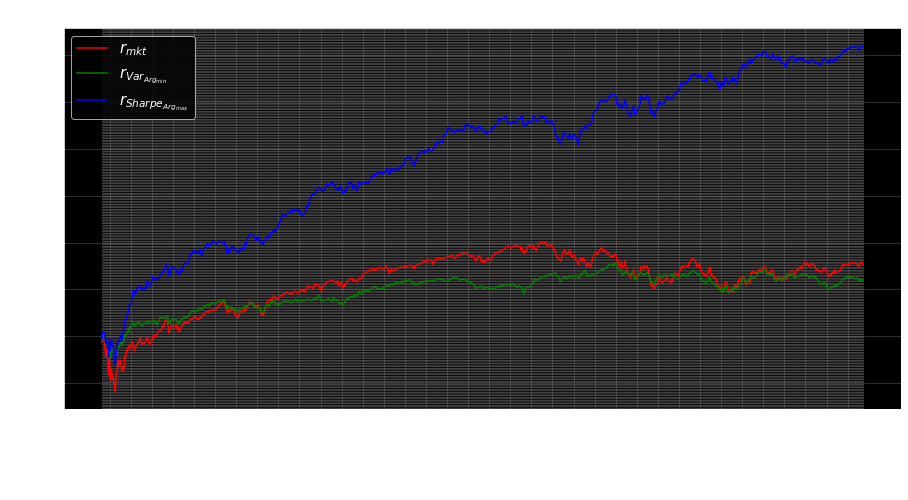

In [127]:
vs.Accum_ts(accum)

##### <font color= 'lightblue'> Metrics: <font>

Confusion Matrix: $\begin{bmatrix} TP & FP \\ FN & TN \end{bmatrix}$

Metrics:

- Accuracy: $\frac{TP + TN}{TP + TN + FP + FN}$ or the ability of the classifier to find + and - samples.

- Precision: $\frac{TP}{TP + FP}$ or the ability of the classifier not to label + samples as -.

- Recall: $\frac{TP}{TP + FN}$ or the ability of the classifier to find all + samples.

- F1 Score: $2 * \frac{Precision * Recall}{Precision + Recall}$ or Precision and Recall equilibrated score through the harmonic mean.    

- ROC AUC: $\frac{TPR}{FPR}$ or the ability of the classifier to find + samples and not - samples. Where a bigger number denotes a better model.

<span style='color:lightyellow'> **Note:** Do not consider the results in this repository or its proceedures as an investment advice or recommendation. <font> 

~ *Past performance is not a guarantee of future results and the market is not always rational.* 

#### <font color= 'gray'>*¿How to reach me?* <font>

[![Website](https://img.shields.io/badge/Website-1f07f5?style=flat-square&logo=google-chrome&logoColor=white)](https://estebanmqz.github.io/Portfolio/)
[![LinkedIn](https://img.shields.io/badge/LinkedIn-173de8?style=flat-square&logo=linkedin&logoColor=white)](https://www.linkedin.com/in/esteban-m-653817205/)
[![E-mail](https://img.shields.io/badge/Business-Mail-083600?style=flat-square&logo=mail&logoColor=white)](mailto:esteban@esteban.com)
[![Github](https://img.shields.io/badge/GitHub-100000?style=flat-square&logo=github&logoColor=white)](https://github.com/EstebanMqz)